# Comparison between different models for the Kaggle challenge "SETI Breakthrough Listen" 

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn import metrics
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sn
import torch
import torch.nn as nn
import torch.nn.functional as F
import random
from efficientnet_pytorch import model as enet
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
import codecs
from PIL import Image

In [2]:
def set_seed(seed = 0):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random_state = np.random.RandomState(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    return random_state

random_state = set_seed(2021)

In [3]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("GPU is available")
else:
    device = torch.device("cpu")
    print("GPU not available, CPU used")

GPU is available


Part of "train/0" -> 1600 samples, ~1.3 GB

In [4]:
df_train=pd.read_csv('./train_labels_shorted.csv')
df_train.head()

,id,target
0,0000799a2b2c42d,0
1,00042890562ff68,0
2,0005364cdcb8e5b,0
3,0007a5a46901c56,0
4,0009283e145448e,0


In [5]:
df_train['img_path']=df_train['id'].apply(lambda x:f'./train/selectiontrain/{x}.npy')
df_train.head()

,id,target,img_path
0,0000799a2b2c42d,0,./train/selectiontrain/0000799a2b2c42d.npy
1,00042890562ff68,0,./train/selectiontrain/00042890562ff68.npy
2,0005364cdcb8e5b,0,./train/selectiontrain/0005364cdcb8e5b.npy
3,0007a5a46901c56,0,./train/selectiontrain/0007a5a46901c56.npy
4,0009283e145448e,0,./train/selectiontrain/0009283e145448e.npy


1600


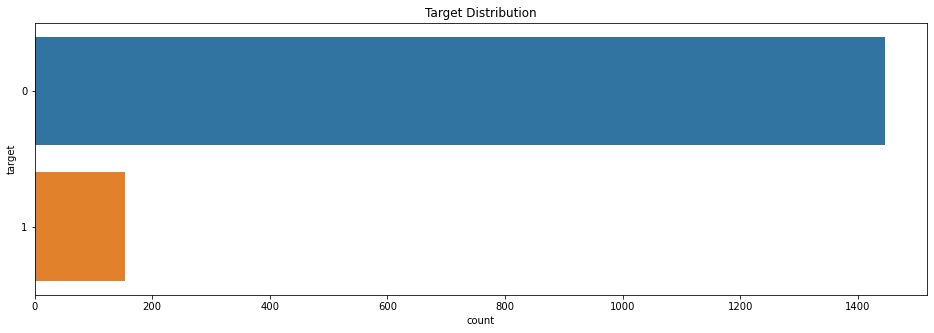

In [6]:
plt.figure(figsize=(16, 5))
sn.countplot(y="target", data=df_train)
plt.title("Target Distribution");
print(len(df_train))

In [7]:
class ClassificationDataset:
    
    def __init__(self, image_paths, targets, augment=False): 
        self.image_paths = image_paths
        self.targets = targets
        self.augment = augment

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, item):      
        image = np.load(self.image_paths[item]).astype(float)
        
        targets = self.targets[item]
        
        if self.augment:
            image = np.vstack(image).transpose((1, 0))
            
            img_pl = Image.fromarray(image).resize((512, 512), resample=Image.BICUBIC)
            image = np.array(img_pl)
                
        return {
            "image": torch.tensor(image, dtype=torch.float) if not self.augment else torch.from_numpy(image).unsqueeze(dim=0),
            "targets": torch.tensor(targets, dtype=torch.long),
        }

In [8]:
class enetv2(nn.Module):
    def __init__(self, backbone, pretrained=False, out_dim=1):
        super(enetv2, self).__init__()
        self.enet = enet.EfficientNet.from_name(backbone)
        if pretrained:
            self.enet.load_state_dict(torch.load(pretrained_model[backbone]))
        self.myfc = nn.Linear(self.enet._fc.in_features, out_dim)
        self.enet._fc = nn.Identity()
        self.conv1 = nn.Conv2d(6, 3, kernel_size=3, stride=1, padding=3, bias=False)
        self.conv1Norm = nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=3, bias=False)
        self.poolNorm = nn.MaxPool2d(2, 2)
        self.conv2Norm = nn.Conv2d(32, 3, kernel_size=3, bias=False)

    def extract(self, x):
        return self.enet(x)

    def forward(self, x):
        flag = x[0][0].shape == (512, 512)
        if flag:
            x = self.conv1Norm(x)
            x = self.poolNorm(x)
            x = self.conv2Norm(x)
        else:
            x = self.conv1(x)
        x = self.extract(x)
        x = self.myfc(x)
        return x

In [9]:
class simpleNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(6, 3, kernel_size=3, stride=1, padding=3, bias=False)
        self.conv1Norm = nn.Conv2d(1, 3, kernel_size=3, stride=1, padding=3, bias=False)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(3, 16, 5)
        self.fc1 = nn.Linear(67536, 120)
        self.fc1Norm = nn.Linear(258064, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 1)
        
    def forward(self, x):
        flag = x[0][0].shape == (512, 512)
        if flag:
            x = self.pool(F.relu(self.conv1Norm(x)))
        else:
            x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1)
        if flag:
            x = F.relu(self.fc1Norm(x))
        else:
            x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [10]:
def train(data_loader, model, optimizer, device):
    
    model.train() # Sets to train mode
    
    loss_sum = 0
    
    for data in tqdm(data_loader, position=0, leave=True, desc='Training'):
        inputs = data["image"]
        targets = data['targets']
        
        # Cast
        inputs = inputs.to(device, dtype=torch.float)
        targets = targets.to(device, dtype=torch.float)
        
        optimizer.zero_grad() # Gradient Descent
        outputs = model(inputs) # Output Weights
        loss = nn.BCEWithLogitsLoss()(outputs, targets.view(-1, 1)) # Loss-Berechnung: BCE-Loss + Sigmoid
        loss_sum += loss
        loss.backward()
        optimizer.step()
        
    return loss_sum
        
def evaluate(data_loader, model, device):
    model.eval() # Sets to evaluation mode
    
    final_targets = []
    final_outputs = []
    
    with torch.no_grad():
        loss_sum = 0
        
        for data in tqdm(data_loader, position=0, leave=True, desc='Evaluating'):
            inputs = data["image"]
            targets = data["targets"]
            inputs = inputs.to(device, dtype=torch.float)
            targets = targets.to(device, dtype=torch.float)
            
            output = model(inputs)
            
            loss_sum += nn.BCEWithLogitsLoss()(output, targets.view(-1, 1))
            
            targets = targets.detach().cpu().numpy().tolist()
            output = output.detach().cpu().numpy().tolist()
            
            final_targets.extend(targets)
            final_outputs.extend(output)
            
    return final_outputs, final_targets, loss_sum

In [11]:
baseline_name = ['efficientnet-b1', 'efficientnet-b3'] # Die Architektur bzw. das Netz? Warum ausgerechnet das?
pretrained_model = {
    baseline_name[0]: './checkpoint/efficientnet-b1-dbc7070a.pth', # Checkpoint?
    baseline_name[1]: './checkpoint/efficientnet-b3-c8376fa2.pth'
}
models = []
device = "cuda"
Batch_Size = 16
X = df_train.img_path.values
Y = df_train.target.values
#skf = StratifiedKFold(n_splits=5) # Cross Validation 5-fold, mehrschichtig (stratified)
# -> https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py)
#fold = 0

starter_models = [simpleNet(), simpleNet(),
                  enetv2(baseline_name[0], pretrained=False, out_dim=1), enetv2(baseline_name[0], pretrained=False, out_dim=1),
                  enetv2(baseline_name[0], pretrained=True, out_dim=1), enetv2(baseline_name[0], pretrained=True, out_dim=1),
                  enetv2(baseline_name[1], pretrained=False, out_dim=1), enetv2(baseline_name[1], pretrained=False, out_dim=1),
                  enetv2(baseline_name[1], pretrained=True, out_dim=1), enetv2(baseline_name[1], pretrained=True, out_dim=1)]

names = ['simpleNet', 'simpleNet-Augment', 'efficientnet-b1', 'efficientnet-b1-augment',
         'efficientnet-b1-pretrained', 'efficientnet-b1-pretrained-augment','efficientnet-b3', 'efficientnet-b3-augment',
         'efficientnet-b3-pretrained', 'efficientnet-b3-pretrained-augment']

epochs = [0 for i in names]
train_losses = [[] for i in names]
valid_losses = [[] for i in names]
aurocs = [[] for i in names]

it = 0

In [12]:
baseline_name = ['efficientnet-b1', 'efficientnet-b3'] # Die Architektur bzw. das Netz? Warum ausgerechnet das?
pretrained_model = {
    baseline_name[0]: './checkpoint/efficientnet-b1-dbc7070a.pth', # Checkpoint?
    baseline_name[1]: './checkpoint/efficientnet-b3-c8376fa2.pth'
}
models = []
device = "cuda"
Batch_Size = 16
X = df_train.img_path.values
Y = df_train.target.values
skf = StratifiedKFold(n_splits=5) # Cross Validation 5-fold, mehrschichtig (stratified)
# -> https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html#sphx-glr-auto-examples-model-selection-plot-cv-indices-py)

starter_models = [simpleNet(), simpleNet(),
                  enetv2(baseline_name[0], pretrained=False, out_dim=1), enetv2(baseline_name[0], pretrained=False, out_dim=1),
                  enetv2(baseline_name[0], pretrained=True, out_dim=1), enetv2(baseline_name[0], pretrained=True, out_dim=1),
                  enetv2(baseline_name[1], pretrained=False, out_dim=1), enetv2(baseline_name[1], pretrained=False, out_dim=1),
                  enetv2(baseline_name[1], pretrained=True, out_dim=1), enetv2(baseline_name[1], pretrained=True, out_dim=1)]

names = ['simpleNet', 'simpleNet-Augment', 'efficientnet-b1', 'efficientnet-b1-augment',
         'efficientnet-b1-pretrained', 'efficientnet-b1-pretrained-augment','efficientnet-b3', 'efficientnet-b3-augment',
         'efficientnet-b3-pretrained', 'efficientnet-b3-pretrained-augment']

epochs = [[0 for i in range(5)] for i in names]
train_losses = [[[] for i in range(5)] for i in names]
valid_losses = [[[] for i in range(5)] for i in names]
aurocs = [[[] for i in range(5)] for i in names]

it = 0
train_losses

[[[], [], [], [], []],
 [[], [], [], [], []],
 [[], [], [], [], []],
 [[], [], [], [], []],
 [[], [], [], [], []],
 [[], [], [], [], []],
 [[], [], [], [], []],
 [[], [], [], [], []],
 [[], [], [], [], []],
 [[], [], [], [], []]]

In [13]:
#create log file
codecs.open('log2.log', 'w+');

In [14]:
for model in starter_models:
    fold = 0
    for train_index, test_index in skf.split(X, Y):
        #train_images, valid_images, train_targets, valid_targets = train_test_split(X, Y, random_state=2021)
        #model = enetv2(baseline_name, out_dim=1)
        starter_models = [simpleNet(), simpleNet(),
                  enetv2(baseline_name[0], pretrained=False, out_dim=1), enetv2(baseline_name[0], pretrained=False, out_dim=1),
                  enetv2(baseline_name[0], pretrained=True, out_dim=1), enetv2(baseline_name[0], pretrained=True, out_dim=1),
                  enetv2(baseline_name[1], pretrained=False, out_dim=1), enetv2(baseline_name[1], pretrained=False, out_dim=1),
                  enetv2(baseline_name[1], pretrained=True, out_dim=1), enetv2(baseline_name[1], pretrained=True, out_dim=1)]
        
        model = starter_models[it]
        model.to(device)

        train_images, valid_images = X[train_index], X[test_index]
        train_targets, valid_targets = Y[train_index], Y[test_index]

        train_dataset = ClassificationDataset(image_paths=train_images, targets=train_targets, augment=it%2!=0)
        valid_dataset = ClassificationDataset(image_paths=valid_images, targets=valid_targets, augment=it%2!=0)
        train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=Batch_Size,shuffle=True, num_workers=4)
        valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=Batch_Size,shuffle=False, num_workers=4)

        optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
        
        row = 0
        last_loss = 0
        train_loss = 10
        
        best_roc_auc = 0

        while epochs[it][fold] < 10:
            if abs(last_loss - train_loss) < 0.01:    
                row += 1
            else:
                row = 0
            last_loss = train_loss
            epochs[it][fold] += 1
            train_loss = train(train_loader, model, optimizer, device=device)
            predictions, valid_targets, valid_loss = evaluate(valid_loader, model, device=device)
            roc_auc = metrics.roc_auc_score(valid_targets, predictions)

            train_losses[it][fold].append(train_loss.detach().cpu().numpy()) 
            valid_losses[it][fold].append(valid_loss.detach().cpu().numpy())
            aurocs[it][fold].append(roc_auc)
            
            if roc_auc > best_roc_auc:
                best_roc_auc = roc_auc

            print(f"Fold {fold}: Epoch={epochs[it][fold]}, Train Loss={train_loss}, Validation Loss={valid_loss}, Validation ROC AUC={roc_auc}")

            with codecs.open('log2.log', 'a') as up:
                up.write(f"Model={names[it]}, Fold={fold} Epoch={epochs[it][fold]}, Train Loss={train_loss}, Valid Loss={valid_loss}, Valid ROC AUC={roc_auc}/{best_roc_auc}\n")

        #torch.save(model.state_dict(), names[it] + '-' + str(it) + '.pt')
        models.append(model)
        fold += 1
    it += 1
    
print('finished')
it = 0

Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 26.08it/s]


Fold 0: Epoch=1, Train Loss=28.763935089111328, Validation Loss=6.447528839111328, Validation ROC AUC=0.5124137931034483


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 26.50it/s]


Fold 0: Epoch=2, Train Loss=25.253440856933594, Validation Loss=7.855048179626465, Validation ROC AUC=0.5259770114942529


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 26.52it/s]


Fold 0: Epoch=3, Train Loss=21.498348236083984, Validation Loss=7.039124011993408, Validation ROC AUC=0.5552873563218391


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 26.05it/s]


Fold 0: Epoch=4, Train Loss=17.137344360351562, Validation Loss=8.7899169921875, Validation ROC AUC=0.5116091954022989


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 27.10it/s]


Fold 0: Epoch=5, Train Loss=11.20960807800293, Validation Loss=9.440117835998535, Validation ROC AUC=0.5127586206896552


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 27.83it/s]


Fold 0: Epoch=6, Train Loss=9.493158340454102, Validation Loss=11.534340858459473, Validation ROC AUC=0.5198850574712643


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 27.66it/s]


Fold 0: Epoch=7, Train Loss=5.31827449798584, Validation Loss=13.180304527282715, Validation ROC AUC=0.5060919540229885


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 27.03it/s]


Fold 0: Epoch=8, Train Loss=3.618710994720459, Validation Loss=16.62100601196289, Validation ROC AUC=0.4917241379310344


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 26.44it/s]


Fold 0: Epoch=9, Train Loss=1.6812679767608643, Validation Loss=18.431787490844727, Validation ROC AUC=0.4614942528735632


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 28.68it/s]


Fold 0: Epoch=10, Train Loss=1.7585504055023193, Validation Loss=16.40042495727539, Validation ROC AUC=0.4902298850574712


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 26.72it/s]


Fold 1: Epoch=1, Train Loss=29.249961853027344, Validation Loss=6.669289588928223, Validation ROC AUC=0.5166871302600736


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 26.99it/s]


Fold 1: Epoch=2, Train Loss=24.862388610839844, Validation Loss=6.807363986968994, Validation ROC AUC=0.5092086170331509


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 26.03it/s]


Fold 1: Epoch=3, Train Loss=22.187786102294922, Validation Loss=7.268771648406982, Validation ROC AUC=0.5538564571938833


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 25.95it/s]


Fold 1: Epoch=4, Train Loss=18.94688606262207, Validation Loss=7.518357276916504, Validation ROC AUC=0.540796963946869


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 27.36it/s]


Fold 1: Epoch=5, Train Loss=14.459433555603027, Validation Loss=7.982429504394531, Validation ROC AUC=0.5870074785132269


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 26.80it/s]


Fold 1: Epoch=6, Train Loss=9.785948753356934, Validation Loss=10.727663040161133, Validation ROC AUC=0.5589909588123675


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 25.83it/s]


Fold 1: Epoch=7, Train Loss=6.946144104003906, Validation Loss=13.136998176574707, Validation ROC AUC=0.5565353276035272


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 26.90it/s]


Fold 1: Epoch=8, Train Loss=4.140835762023926, Validation Loss=12.675759315490723, Validation ROC AUC=0.5574282844067419


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 27.21it/s]


Fold 1: Epoch=9, Train Loss=2.8325865268707275, Validation Loss=16.688936233520508, Validation ROC AUC=0.561223350820404


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 25.84it/s]


Fold 1: Epoch=10, Train Loss=3.279668092727661, Validation Loss=15.900038719177246, Validation ROC AUC=0.5756222792722402


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 25.70it/s]


Fold 2: Epoch=1, Train Loss=29.914819717407227, Validation Loss=6.516053676605225, Validation ROC AUC=0.4780667485210402


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 26.48it/s]


Fold 2: Epoch=2, Train Loss=24.540809631347656, Validation Loss=6.7784743309021, Validation ROC AUC=0.4753878781113964


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 26.10it/s]


Fold 2: Epoch=3, Train Loss=20.970138549804688, Validation Loss=7.508935451507568, Validation ROC AUC=0.4314097555530751


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 26.62it/s]


Fold 2: Epoch=4, Train Loss=17.892250061035156, Validation Loss=7.9441375732421875, Validation ROC AUC=0.45116642482419916


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 26.61it/s]


Fold 2: Epoch=5, Train Loss=12.668386459350586, Validation Loss=9.446837425231934, Validation ROC AUC=0.4780667485210403


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 27.00it/s]


Fold 2: Epoch=6, Train Loss=7.654870510101318, Validation Loss=12.303547859191895, Validation ROC AUC=0.44826431521375154


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 25.70it/s]


Fold 2: Epoch=7, Train Loss=6.4161295890808105, Validation Loss=13.795204162597656, Validation ROC AUC=0.47036499609331395


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 26.72it/s]


Fold 2: Epoch=8, Train Loss=3.432713747024536, Validation Loss=19.9647274017334, Validation ROC AUC=0.46043085165755104


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 26.12it/s]


Fold 2: Epoch=9, Train Loss=2.2420601844787598, Validation Loss=17.6585750579834, Validation ROC AUC=0.4461435428061168


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 25.43it/s]


Fold 2: Epoch=10, Train Loss=1.8134117126464844, Validation Loss=22.302528381347656, Validation ROC AUC=0.4540685344346468


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 25.10it/s]


Fold 3: Epoch=1, Train Loss=29.865419387817383, Validation Loss=6.701414108276367, Validation ROC AUC=0.4564125460430852


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 26.42it/s]


Fold 3: Epoch=2, Train Loss=24.755617141723633, Validation Loss=6.755218029022217, Validation ROC AUC=0.4569706440450943


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 26.99it/s]


Fold 3: Epoch=3, Train Loss=22.563514709472656, Validation Loss=7.927812576293945, Validation ROC AUC=0.4343118651635227


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 25.71it/s]


Fold 3: Epoch=4, Train Loss=17.96506690979004, Validation Loss=7.726346015930176, Validation ROC AUC=0.4310748967518697


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 27.20it/s]


Fold 3: Epoch=5, Train Loss=11.970521926879883, Validation Loss=9.87018871307373, Validation ROC AUC=0.39345909141645274


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 26.11it/s]


Fold 3: Epoch=6, Train Loss=8.641716957092285, Validation Loss=10.609264373779297, Validation ROC AUC=0.36410313651077125


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 25.30it/s]


Fold 3: Epoch=7, Train Loss=6.276161193847656, Validation Loss=13.256089210510254, Validation ROC AUC=0.37225136734010494


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 25.67it/s]


Fold 3: Epoch=8, Train Loss=2.9993488788604736, Validation Loss=16.12998390197754, Validation ROC AUC=0.3912266994084161


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 26.07it/s]


Fold 3: Epoch=9, Train Loss=2.540407180786133, Validation Loss=21.648521423339844, Validation ROC AUC=0.3710235517356848


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 26.81it/s]


Fold 3: Epoch=10, Train Loss=1.2342839241027832, Validation Loss=21.60719871520996, Validation ROC AUC=0.3658890501172005


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 26.00it/s]


Fold 4: Epoch=1, Train Loss=28.872329711914062, Validation Loss=6.666104316711426, Validation ROC AUC=0.49090300256725083


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 25.77it/s]


Fold 4: Epoch=2, Train Loss=24.368560791015625, Validation Loss=6.682554244995117, Validation ROC AUC=0.46802098448487556


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 25.32it/s]


Fold 4: Epoch=3, Train Loss=23.346080780029297, Validation Loss=6.959936141967773, Validation ROC AUC=0.4537336756334413


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 25.64it/s]


Fold 4: Epoch=4, Train Loss=19.7750186920166, Validation Loss=8.096114158630371, Validation ROC AUC=0.4397812255832125


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 26.74it/s]


Fold 4: Epoch=5, Train Loss=18.23386573791504, Validation Loss=8.537686347961426, Validation ROC AUC=0.48721955575399034


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 27.80it/s]


Fold 4: Epoch=6, Train Loss=12.267815589904785, Validation Loss=10.936335563659668, Validation ROC AUC=0.4394463667820069


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 25.11it/s]


Fold 4: Epoch=7, Train Loss=9.286195755004883, Validation Loss=11.563761711120605, Validation ROC AUC=0.45272909922982474


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 26.82it/s]


Fold 4: Epoch=8, Train Loss=6.728960990905762, Validation Loss=12.896510124206543, Validation ROC AUC=0.43330728875990626


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 25.58it/s]


Fold 4: Epoch=9, Train Loss=3.9300990104675293, Validation Loss=13.983163833618164, Validation ROC AUC=0.4393347471816051


Evaluating: 100%|███████████████████████████████| 20/20 [00:00<00:00, 27.28it/s]


Fold 4: Epoch=10, Train Loss=2.6787924766540527, Validation Loss=17.62804412841797, Validation ROC AUC=0.45786360084830896


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.79it/s]


Fold 0: Epoch=1, Train Loss=32.09109878540039, Validation Loss=6.876509189605713, Validation ROC AUC=0.4768965517241379


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.91it/s]


Fold 0: Epoch=2, Train Loss=22.09521484375, Validation Loss=8.285123825073242, Validation ROC AUC=0.4929885057471264


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.27it/s]


Fold 0: Epoch=3, Train Loss=15.169648170471191, Validation Loss=9.052490234375, Validation ROC AUC=0.4627586206896551


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.74it/s]


Fold 0: Epoch=4, Train Loss=9.7454252243042, Validation Loss=10.046515464782715, Validation ROC AUC=0.44701149425287356


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.92it/s]


Fold 0: Epoch=5, Train Loss=6.111310005187988, Validation Loss=13.65466022491455, Validation ROC AUC=0.442183908045977


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.96it/s]


Fold 0: Epoch=6, Train Loss=4.08316707611084, Validation Loss=14.36807918548584, Validation ROC AUC=0.45218390804597697


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.57it/s]


Fold 0: Epoch=7, Train Loss=2.8276662826538086, Validation Loss=15.972553253173828, Validation ROC AUC=0.5079310344827587


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.82it/s]


Fold 0: Epoch=8, Train Loss=2.4847264289855957, Validation Loss=17.770763397216797, Validation ROC AUC=0.49551724137931036


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.50it/s]


Fold 0: Epoch=9, Train Loss=3.091417074203491, Validation Loss=14.871185302734375, Validation ROC AUC=0.507816091954023


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.67it/s]


Fold 0: Epoch=10, Train Loss=1.4732612371444702, Validation Loss=20.37785530090332, Validation ROC AUC=0.4926436781609196


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.80it/s]


Fold 1: Epoch=1, Train Loss=28.433727264404297, Validation Loss=6.748490810394287, Validation ROC AUC=0.5147895970532425


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.17it/s]


Fold 1: Epoch=2, Train Loss=24.759414672851562, Validation Loss=6.874383926391602, Validation ROC AUC=0.4970420805893515


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.91it/s]


Fold 1: Epoch=3, Train Loss=22.31165885925293, Validation Loss=7.471765995025635, Validation ROC AUC=0.49056814376604535


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.56it/s]


Fold 1: Epoch=4, Train Loss=17.96745491027832, Validation Loss=9.346366882324219, Validation ROC AUC=0.5049670722178814


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.45it/s]


Fold 1: Epoch=5, Train Loss=12.167123794555664, Validation Loss=9.48192024230957, Validation ROC AUC=0.505971648621498


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.45it/s]


Fold 1: Epoch=6, Train Loss=7.883181571960449, Validation Loss=11.474303245544434, Validation ROC AUC=0.5104364326375712


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.04it/s]


Fold 1: Epoch=7, Train Loss=5.033202648162842, Validation Loss=17.027490615844727, Validation ROC AUC=0.4654537336756335


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.39it/s]


Fold 1: Epoch=8, Train Loss=3.4083640575408936, Validation Loss=20.361486434936523, Validation ROC AUC=0.4646723964728206


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.32it/s]


Fold 1: Epoch=9, Train Loss=3.740980863571167, Validation Loss=22.290897369384766, Validation ROC AUC=0.47092309409532307


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.39it/s]


Fold 1: Epoch=10, Train Loss=2.448861598968506, Validation Loss=21.546810150146484, Validation ROC AUC=0.4709230940953231


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 12.22it/s]


Fold 2: Epoch=1, Train Loss=30.29911994934082, Validation Loss=6.792492389678955, Validation ROC AUC=0.6028574617702869


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 12.18it/s]


Fold 2: Epoch=2, Train Loss=24.36552619934082, Validation Loss=6.586696147918701, Validation ROC AUC=0.5865610001116196


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.99it/s]


Fold 2: Epoch=3, Train Loss=21.535263061523438, Validation Loss=7.077483654022217, Validation ROC AUC=0.5916955017301038


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.78it/s]


Fold 2: Epoch=4, Train Loss=15.30420970916748, Validation Loss=8.461113929748535, Validation ROC AUC=0.5509543475834356


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 12.13it/s]


Fold 2: Epoch=5, Train Loss=9.997119903564453, Validation Loss=8.728403091430664, Validation ROC AUC=0.579752204487108


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.71it/s]


Fold 2: Epoch=6, Train Loss=5.554717540740967, Validation Loss=11.1644926071167, Validation ROC AUC=0.5511775867842392


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.61it/s]


Fold 2: Epoch=7, Train Loss=3.206566095352173, Validation Loss=13.208677291870117, Validation ROC AUC=0.5812032592923317


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.92it/s]


Fold 2: Epoch=8, Train Loss=1.7442042827606201, Validation Loss=14.637173652648926, Validation ROC AUC=0.5742828440674183


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 12.06it/s]


Fold 2: Epoch=9, Train Loss=1.7576806545257568, Validation Loss=14.818120956420898, Validation ROC AUC=0.5789708672842951


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 12.20it/s]


Fold 2: Epoch=10, Train Loss=0.8950296640396118, Validation Loss=20.610647201538086, Validation ROC AUC=0.5685902444469249


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.76it/s]


Fold 3: Epoch=1, Train Loss=32.90857696533203, Validation Loss=6.507306098937988, Validation ROC AUC=0.5603303940171894


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.73it/s]


Fold 3: Epoch=2, Train Loss=23.574094772338867, Validation Loss=8.020222663879395, Validation ROC AUC=0.4814153365330952


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.98it/s]


Fold 3: Epoch=3, Train Loss=19.70438575744629, Validation Loss=7.717906475067139, Validation ROC AUC=0.49079138296684893


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.75it/s]


Fold 3: Epoch=4, Train Loss=14.918580055236816, Validation Loss=8.882040023803711, Validation ROC AUC=0.4556312088402724


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.57it/s]


Fold 3: Epoch=5, Train Loss=10.654692649841309, Validation Loss=10.684618949890137, Validation ROC AUC=0.4771737917178256


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 12.12it/s]


Fold 3: Epoch=6, Train Loss=6.899786949157715, Validation Loss=12.036958694458008, Validation ROC AUC=0.4954794061837258


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.94it/s]


Fold 3: Epoch=7, Train Loss=5.307311534881592, Validation Loss=20.106201171875, Validation ROC AUC=0.44580868400491125


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.62it/s]


Fold 3: Epoch=8, Train Loss=4.138636589050293, Validation Loss=18.86882781982422, Validation ROC AUC=0.41689920750083714


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.77it/s]


Fold 3: Epoch=9, Train Loss=3.5827105045318604, Validation Loss=18.128936767578125, Validation ROC AUC=0.46645831007924987


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.96it/s]


Fold 3: Epoch=10, Train Loss=1.415929913520813, Validation Loss=23.24350357055664, Validation ROC AUC=0.4410090411876325


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 12.03it/s]


Fold 4: Epoch=1, Train Loss=30.280309677124023, Validation Loss=6.759848594665527, Validation ROC AUC=0.4866614577519813


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.71it/s]


Fold 4: Epoch=2, Train Loss=21.71923065185547, Validation Loss=7.932791233062744, Validation ROC AUC=0.4932470141756893


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.58it/s]


Fold 4: Epoch=3, Train Loss=16.7808780670166, Validation Loss=8.090118408203125, Validation ROC AUC=0.50731108382632


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 12.35it/s]


Fold 4: Epoch=4, Train Loss=11.987282752990723, Validation Loss=10.893749237060547, Validation ROC AUC=0.5233843062841834


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 12.05it/s]


Fold 4: Epoch=5, Train Loss=5.954212188720703, Validation Loss=13.616464614868164, Validation ROC AUC=0.521710012278156


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.93it/s]


Fold 4: Epoch=6, Train Loss=3.790956497192383, Validation Loss=14.081241607666016, Validation ROC AUC=0.5266212746958366


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.76it/s]


Fold 4: Epoch=7, Train Loss=2.610858678817749, Validation Loss=15.300780296325684, Validation ROC AUC=0.5329835919187409


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 12.34it/s]


Fold 4: Epoch=8, Train Loss=1.3209106922149658, Validation Loss=17.346376419067383, Validation ROC AUC=0.5181381850652974


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 12.13it/s]


Fold 4: Epoch=9, Train Loss=0.9682090282440186, Validation Loss=19.688018798828125, Validation ROC AUC=0.5162406518584663


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 12.26it/s]


Fold 4: Epoch=10, Train Loss=0.5003935694694519, Validation Loss=19.978439331054688, Validation ROC AUC=0.5173568478624846


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.80it/s]


Fold 0: Epoch=1, Train Loss=31.997156143188477, Validation Loss=8.462182998657227, Validation ROC AUC=0.4689655172413793


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.92it/s]


Fold 0: Epoch=2, Train Loss=26.80869483947754, Validation Loss=7.329370975494385, Validation ROC AUC=0.5006321839080459


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 17.35it/s]


Fold 0: Epoch=3, Train Loss=25.62485694885254, Validation Loss=6.437896251678467, Validation ROC AUC=0.47431034482758616


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 15.62it/s]


Fold 0: Epoch=4, Train Loss=26.15630340576172, Validation Loss=6.309298515319824, Validation ROC AUC=0.5449425287356323


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.49it/s]


Fold 0: Epoch=5, Train Loss=26.10218048095703, Validation Loss=6.2796478271484375, Validation ROC AUC=0.4801724137931034


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 17.20it/s]


Fold 0: Epoch=6, Train Loss=26.050716400146484, Validation Loss=6.266177177429199, Validation ROC AUC=0.49632183908045974


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 17.53it/s]


Fold 0: Epoch=7, Train Loss=26.64059066772461, Validation Loss=6.222231864929199, Validation ROC AUC=0.4944827586206897


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.98it/s]


Fold 0: Epoch=8, Train Loss=26.08517074584961, Validation Loss=6.5048909187316895, Validation ROC AUC=0.536896551724138


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 17.02it/s]


Fold 0: Epoch=9, Train Loss=25.646085739135742, Validation Loss=6.717095375061035, Validation ROC AUC=0.3873563218390805


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.90it/s]


Fold 0: Epoch=10, Train Loss=25.66159439086914, Validation Loss=6.431602954864502, Validation ROC AUC=0.4904597701149426


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 17.21it/s]


Fold 1: Epoch=1, Train Loss=31.367252349853516, Validation Loss=8.840532302856445, Validation ROC AUC=0.5


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.80it/s]


Fold 1: Epoch=2, Train Loss=26.544673919677734, Validation Loss=6.399955749511719, Validation ROC AUC=0.5161290322580645


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 17.20it/s]


Fold 1: Epoch=3, Train Loss=27.171321868896484, Validation Loss=6.366905689239502, Validation ROC AUC=0.5425270677530974


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 17.11it/s]


Fold 1: Epoch=4, Train Loss=26.49622917175293, Validation Loss=6.405361652374268, Validation ROC AUC=0.521710012278156


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 17.21it/s]


Fold 1: Epoch=5, Train Loss=26.598691940307617, Validation Loss=6.400247097015381, Validation ROC AUC=0.5834356513003683


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 17.06it/s]


Fold 1: Epoch=6, Train Loss=26.10894012451172, Validation Loss=6.405914306640625, Validation ROC AUC=0.5156825538564572


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.63it/s]


Fold 1: Epoch=7, Train Loss=26.03002166748047, Validation Loss=6.525970458984375, Validation ROC AUC=0.48163857573389884


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.62it/s]


Fold 1: Epoch=8, Train Loss=25.859474182128906, Validation Loss=6.795668125152588, Validation ROC AUC=0.46310972206719503


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.80it/s]


Fold 1: Epoch=9, Train Loss=25.68423080444336, Validation Loss=6.313692569732666, Validation ROC AUC=0.5376716151356178


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 17.90it/s]


Fold 1: Epoch=10, Train Loss=25.798173904418945, Validation Loss=6.922353744506836, Validation ROC AUC=0.43107489675186966


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.95it/s]


Fold 2: Epoch=1, Train Loss=31.18743896484375, Validation Loss=8.089200973510742, Validation ROC AUC=0.4819176247349035


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.96it/s]


Fold 2: Epoch=2, Train Loss=26.83494758605957, Validation Loss=6.409587860107422, Validation ROC AUC=0.49503292778211855


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 17.56it/s]


Fold 2: Epoch=3, Train Loss=26.42120933532715, Validation Loss=6.446625232696533, Validation ROC AUC=0.5944859917401495


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 17.19it/s]


Fold 2: Epoch=4, Train Loss=26.640905380249023, Validation Loss=6.473902225494385, Validation ROC AUC=0.5814823082933364


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.22it/s]


Fold 2: Epoch=5, Train Loss=26.090858459472656, Validation Loss=6.399204730987549, Validation ROC AUC=0.485545261747963


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.65it/s]


Fold 2: Epoch=6, Train Loss=26.037012100219727, Validation Loss=7.1659040451049805, Validation ROC AUC=0.558656100011162


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.83it/s]


Fold 2: Epoch=7, Train Loss=26.114429473876953, Validation Loss=6.385880470275879, Validation ROC AUC=0.4725973881013506


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.65it/s]


Fold 2: Epoch=8, Train Loss=25.365642547607422, Validation Loss=6.478202819824219, Validation ROC AUC=0.5113293894407858


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 17.14it/s]


Fold 2: Epoch=9, Train Loss=25.6337947845459, Validation Loss=6.481391906738281, Validation ROC AUC=0.5167987498604756


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 17.28it/s]


Fold 2: Epoch=10, Train Loss=25.884475708007812, Validation Loss=6.586336135864258, Validation ROC AUC=0.4952561669829222


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 17.16it/s]


Fold 3: Epoch=1, Train Loss=31.294466018676758, Validation Loss=7.568690776824951, Validation ROC AUC=0.4689697510882911


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.59it/s]


Fold 3: Epoch=2, Train Loss=27.62395668029785, Validation Loss=6.494287967681885, Validation ROC AUC=0.4554079696394687


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 17.38it/s]


Fold 3: Epoch=3, Train Loss=26.660167694091797, Validation Loss=6.363458633422852, Validation ROC AUC=0.5695948208505414


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 17.20it/s]


Fold 3: Epoch=4, Train Loss=25.768735885620117, Validation Loss=6.485145568847656, Validation ROC AUC=0.571045875655765


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 17.59it/s]


Fold 3: Epoch=5, Train Loss=25.738765716552734, Validation Loss=6.525556564331055, Validation ROC AUC=0.6467239647282063


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.84it/s]


Fold 3: Epoch=6, Train Loss=25.6015625, Validation Loss=6.462484359741211, Validation ROC AUC=0.6275253934590914


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.94it/s]


Fold 3: Epoch=7, Train Loss=25.678813934326172, Validation Loss=6.396096706390381, Validation ROC AUC=0.489451947762027


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 17.26it/s]


Fold 3: Epoch=8, Train Loss=25.6104679107666, Validation Loss=6.493744850158691, Validation ROC AUC=0.46802098448487556


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.53it/s]


Fold 3: Epoch=9, Train Loss=25.655847549438477, Validation Loss=7.849972248077393, Validation ROC AUC=0.4811920973322915


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.74it/s]


Fold 3: Epoch=10, Train Loss=25.21232032775879, Validation Loss=6.461300849914551, Validation ROC AUC=0.5135617814488224


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.58it/s]


Fold 4: Epoch=1, Train Loss=31.41887092590332, Validation Loss=9.72729206085205, Validation ROC AUC=0.47750865051903113


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.96it/s]


Fold 4: Epoch=2, Train Loss=27.132152557373047, Validation Loss=6.801277160644531, Validation ROC AUC=0.5100457640361648


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.58it/s]


Fold 4: Epoch=3, Train Loss=26.31831169128418, Validation Loss=6.372984886169434, Validation ROC AUC=0.5740596048666146


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 17.09it/s]


Fold 4: Epoch=4, Train Loss=26.339372634887695, Validation Loss=6.366583347320557, Validation ROC AUC=0.41098336867954016


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.35it/s]


Fold 4: Epoch=5, Train Loss=26.007993698120117, Validation Loss=6.815495491027832, Validation ROC AUC=0.47516463891059274


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.57it/s]


Fold 4: Epoch=6, Train Loss=25.51097869873047, Validation Loss=6.402633190155029, Validation ROC AUC=0.5123339658444022


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 15.96it/s]


Fold 4: Epoch=7, Train Loss=25.659666061401367, Validation Loss=7.297752857208252, Validation ROC AUC=0.5325371135171336


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.62it/s]


Fold 4: Epoch=8, Train Loss=25.46405601501465, Validation Loss=6.836542129516602, Validation ROC AUC=0.39368233061725644


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 17.45it/s]


Fold 4: Epoch=9, Train Loss=25.74094581604004, Validation Loss=6.462161064147949, Validation ROC AUC=0.5021765822078357


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 17.14it/s]


Fold 4: Epoch=10, Train Loss=25.613033294677734, Validation Loss=6.530138969421387, Validation ROC AUC=0.49547940618372593


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.88it/s]


Fold 0: Epoch=1, Train Loss=31.799644470214844, Validation Loss=8.226479530334473, Validation ROC AUC=0.4747701149425287


Evaluating: 100%|███████████████████████████████| 20/20 [00:02<00:00,  9.87it/s]


Fold 0: Epoch=2, Train Loss=27.301082611083984, Validation Loss=6.5658464431762695, Validation ROC AUC=0.44683908045977017


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.63it/s]


Fold 0: Epoch=3, Train Loss=26.955394744873047, Validation Loss=6.255385875701904, Validation ROC AUC=0.5567241379310346


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.93it/s]


Fold 0: Epoch=4, Train Loss=26.667255401611328, Validation Loss=6.2601399421691895, Validation ROC AUC=0.6181609195402299


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.75it/s]


Fold 0: Epoch=5, Train Loss=26.61914825439453, Validation Loss=6.246192455291748, Validation ROC AUC=0.3737931034482759


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.86it/s]


Fold 0: Epoch=6, Train Loss=26.097307205200195, Validation Loss=6.269876480102539, Validation ROC AUC=0.4711494252873563


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.34it/s]


Fold 0: Epoch=7, Train Loss=26.346355438232422, Validation Loss=6.6999335289001465, Validation ROC AUC=0.46011494252873564


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.09it/s]


Fold 0: Epoch=8, Train Loss=26.58893394470215, Validation Loss=6.263324737548828, Validation ROC AUC=0.5197701149425287


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.83it/s]


Fold 0: Epoch=9, Train Loss=26.00312042236328, Validation Loss=6.370931148529053, Validation ROC AUC=0.45678160919540234


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.89it/s]


Fold 0: Epoch=10, Train Loss=25.73122787475586, Validation Loss=6.370548725128174, Validation ROC AUC=0.548735632183908


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.06it/s]


Fold 1: Epoch=1, Train Loss=30.31186294555664, Validation Loss=8.79460334777832, Validation ROC AUC=0.5


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.82it/s]


Fold 1: Epoch=2, Train Loss=29.090768814086914, Validation Loss=6.432598114013672, Validation ROC AUC=0.4839267775421364


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.07it/s]


Fold 1: Epoch=3, Train Loss=26.76797103881836, Validation Loss=6.364930629730225, Validation ROC AUC=0.43464672396472825


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.45it/s]


Fold 1: Epoch=4, Train Loss=26.800329208374023, Validation Loss=6.514477252960205, Validation ROC AUC=0.4957584551847305


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.37it/s]


Fold 1: Epoch=5, Train Loss=26.593692779541016, Validation Loss=6.414435386657715, Validation ROC AUC=0.5115526286415895


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.45it/s]


Fold 1: Epoch=6, Train Loss=25.86128044128418, Validation Loss=6.464385032653809, Validation ROC AUC=0.4740484429065744


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.44it/s]


Fold 1: Epoch=7, Train Loss=26.167495727539062, Validation Loss=6.735591411590576, Validation ROC AUC=0.44826431521375154


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.06it/s]


Fold 1: Epoch=8, Train Loss=25.67488670349121, Validation Loss=6.41030216217041, Validation ROC AUC=0.5096550954347584


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.24it/s]


Fold 1: Epoch=9, Train Loss=25.905807495117188, Validation Loss=6.414945602416992, Validation ROC AUC=0.47438330170777987


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.19it/s]


Fold 1: Epoch=10, Train Loss=25.767074584960938, Validation Loss=6.3734450340271, Validation ROC AUC=0.5423596383524947


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.81it/s]


Fold 2: Epoch=1, Train Loss=31.203336715698242, Validation Loss=7.406494617462158, Validation ROC AUC=0.5687018640473267


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.72it/s]


Fold 2: Epoch=2, Train Loss=28.26040267944336, Validation Loss=6.437297821044922, Validation ROC AUC=0.4883357517580087


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.69it/s]


Fold 2: Epoch=3, Train Loss=26.342809677124023, Validation Loss=6.414566516876221, Validation ROC AUC=0.40562562786025225


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.05it/s]


Fold 2: Epoch=4, Train Loss=26.00423812866211, Validation Loss=6.382003307342529, Validation ROC AUC=0.46137961826096663


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.83it/s]


Fold 2: Epoch=5, Train Loss=25.206422805786133, Validation Loss=6.952212810516357, Validation ROC AUC=0.5384529523384306


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.64it/s]


Fold 2: Epoch=6, Train Loss=25.67724609375, Validation Loss=6.3312225341796875, Validation ROC AUC=0.5498381515794173


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.26it/s]


Fold 2: Epoch=7, Train Loss=25.80295181274414, Validation Loss=6.346866130828857, Validation ROC AUC=0.5468244223685679


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.13it/s]


Fold 2: Epoch=8, Train Loss=24.53489875793457, Validation Loss=8.262378692626953, Validation ROC AUC=0.5185846634669047


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.15it/s]


Fold 2: Epoch=9, Train Loss=24.24332618713379, Validation Loss=6.627025604248047, Validation ROC AUC=0.5277374706998549


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.94it/s]


Fold 2: Epoch=10, Train Loss=23.836000442504883, Validation Loss=6.736611366271973, Validation ROC AUC=0.5173568478624847


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.10it/s]


Fold 3: Epoch=1, Train Loss=31.252843856811523, Validation Loss=9.008313179016113, Validation ROC AUC=0.4648398258734234


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.23it/s]


Fold 3: Epoch=2, Train Loss=27.268619537353516, Validation Loss=6.428720474243164, Validation ROC AUC=0.4276146891394129


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.82it/s]


Fold 3: Epoch=3, Train Loss=26.731616973876953, Validation Loss=6.89949893951416, Validation ROC AUC=0.43219109275588785


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.83it/s]


Fold 3: Epoch=4, Train Loss=26.1102237701416, Validation Loss=6.7781572341918945, Validation ROC AUC=0.529635003906686


Evaluating: 100%|███████████████████████████████| 20/20 [00:02<00:00,  9.58it/s]


Fold 3: Epoch=5, Train Loss=25.856481552124023, Validation Loss=6.3432393074035645, Validation ROC AUC=0.6240651858466346


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.70it/s]


Fold 3: Epoch=6, Train Loss=26.46766471862793, Validation Loss=6.445166110992432, Validation ROC AUC=0.5063065074227033


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.98it/s]


Fold 3: Epoch=7, Train Loss=25.62425422668457, Validation Loss=6.718989849090576, Validation ROC AUC=0.4458086840049113


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.42it/s]


Fold 3: Epoch=8, Train Loss=25.62976837158203, Validation Loss=6.55857515335083, Validation ROC AUC=0.4589797968523273


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.38it/s]


Fold 3: Epoch=9, Train Loss=25.660110473632812, Validation Loss=6.383944988250732, Validation ROC AUC=0.5580980020091528


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.93it/s]


Fold 3: Epoch=10, Train Loss=25.566600799560547, Validation Loss=6.916104316711426, Validation ROC AUC=0.5452617479629422


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.00it/s]


Fold 4: Epoch=1, Train Loss=30.049819946289062, Validation Loss=9.361583709716797, Validation ROC AUC=0.496093313985936


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.58it/s]


Fold 4: Epoch=2, Train Loss=26.4471435546875, Validation Loss=6.689465045928955, Validation ROC AUC=0.5067529858243107


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.80it/s]


Fold 4: Epoch=3, Train Loss=26.248401641845703, Validation Loss=6.533975601196289, Validation ROC AUC=0.5077017524277263


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.77it/s]


Fold 4: Epoch=4, Train Loss=26.55186653137207, Validation Loss=8.403372764587402, Validation ROC AUC=0.39775644603192317


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.86it/s]


Fold 4: Epoch=5, Train Loss=25.987770080566406, Validation Loss=6.398283958435059, Validation ROC AUC=0.39401718941846187


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.82it/s]


Fold 4: Epoch=6, Train Loss=25.583738327026367, Validation Loss=6.551590442657471, Validation ROC AUC=0.4404509431856234


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.03it/s]


Fold 4: Epoch=7, Train Loss=25.56071662902832, Validation Loss=6.708902835845947, Validation ROC AUC=0.4708114744949213


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.98it/s]


Fold 4: Epoch=8, Train Loss=25.358999252319336, Validation Loss=7.001554489135742, Validation ROC AUC=0.43207947315548606


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.19it/s]


Fold 4: Epoch=9, Train Loss=25.488954544067383, Validation Loss=6.677985668182373, Validation ROC AUC=0.4588681772519254


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.88it/s]


Fold 4: Epoch=10, Train Loss=24.84077262878418, Validation Loss=7.432600498199463, Validation ROC AUC=0.5074227034267218


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.78it/s]


Fold 0: Epoch=1, Train Loss=30.805776596069336, Validation Loss=7.475583553314209, Validation ROC AUC=0.5550574712643679


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 17.50it/s]


Fold 0: Epoch=2, Train Loss=23.913475036621094, Validation Loss=8.10373592376709, Validation ROC AUC=0.5259770114942528


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.91it/s]


Fold 0: Epoch=3, Train Loss=19.139219284057617, Validation Loss=9.263886451721191, Validation ROC AUC=0.4357471264367816


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.24it/s]


Fold 0: Epoch=4, Train Loss=17.38544464111328, Validation Loss=8.991403579711914, Validation ROC AUC=0.5149425287356322


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 15.78it/s]


Fold 0: Epoch=5, Train Loss=11.714302062988281, Validation Loss=9.7076416015625, Validation ROC AUC=0.5054022988505747


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.12it/s]


Fold 0: Epoch=6, Train Loss=6.340265274047852, Validation Loss=15.193917274475098, Validation ROC AUC=0.5632183908045978


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.95it/s]


Fold 0: Epoch=7, Train Loss=6.186429500579834, Validation Loss=13.942025184631348, Validation ROC AUC=0.4572413793103448


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.88it/s]


Fold 0: Epoch=8, Train Loss=7.48464822769165, Validation Loss=15.126049041748047, Validation ROC AUC=0.5322988505747126


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.77it/s]


Fold 0: Epoch=9, Train Loss=6.4709343910217285, Validation Loss=11.886488914489746, Validation ROC AUC=0.5110344827586206


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 17.56it/s]


Fold 0: Epoch=10, Train Loss=4.206832408905029, Validation Loss=15.069878578186035, Validation ROC AUC=0.5310344827586206


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 17.08it/s]


Fold 1: Epoch=1, Train Loss=30.999967575073242, Validation Loss=7.33547830581665, Validation ROC AUC=0.526398035495033


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.71it/s]


Fold 1: Epoch=2, Train Loss=23.412456512451172, Validation Loss=7.5281243324279785, Validation ROC AUC=0.5392342895412435


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.51it/s]


Fold 1: Epoch=3, Train Loss=17.27543830871582, Validation Loss=8.611161231994629, Validation ROC AUC=0.5132269226476169


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.63it/s]


Fold 1: Epoch=4, Train Loss=10.990325927734375, Validation Loss=11.0745267868042, Validation ROC AUC=0.5787476280834914


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 17.01it/s]


Fold 1: Epoch=5, Train Loss=10.235734939575195, Validation Loss=18.28144073486328, Validation ROC AUC=0.5743944636678201


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.66it/s]


Fold 1: Epoch=6, Train Loss=8.142251968383789, Validation Loss=14.377778053283691, Validation ROC AUC=0.5123339658444023


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.89it/s]


Fold 1: Epoch=7, Train Loss=7.365537166595459, Validation Loss=13.899188995361328, Validation ROC AUC=0.5824310748967518


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 15.96it/s]


Fold 1: Epoch=8, Train Loss=4.4645609855651855, Validation Loss=17.065902709960938, Validation ROC AUC=0.5563120884027235


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 17.04it/s]


Fold 1: Epoch=9, Train Loss=4.920931339263916, Validation Loss=14.565616607666016, Validation ROC AUC=0.5361089407299922


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.93it/s]


Fold 1: Epoch=10, Train Loss=2.56442928314209, Validation Loss=15.38794994354248, Validation ROC AUC=0.567808907244112


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 17.03it/s]


Fold 2: Epoch=1, Train Loss=30.473281860351562, Validation Loss=7.958031177520752, Validation ROC AUC=0.4916843397700636


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 17.69it/s]


Fold 2: Epoch=2, Train Loss=22.762678146362305, Validation Loss=8.054876327514648, Validation ROC AUC=0.455854448041076


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.65it/s]


Fold 2: Epoch=3, Train Loss=17.921396255493164, Validation Loss=9.747097969055176, Validation ROC AUC=0.45406853443464673


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 17.11it/s]


Fold 2: Epoch=4, Train Loss=12.997859954833984, Validation Loss=12.000700950622559, Validation ROC AUC=0.571827212858578


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.15it/s]


Fold 2: Epoch=5, Train Loss=10.78288459777832, Validation Loss=15.035184860229492, Validation ROC AUC=0.5367786583324032


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 15.58it/s]


Fold 2: Epoch=6, Train Loss=7.0916056632995605, Validation Loss=12.978947639465332, Validation ROC AUC=0.5169103694608773


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 15.95it/s]


Fold 2: Epoch=7, Train Loss=3.777580499649048, Validation Loss=14.209169387817383, Validation ROC AUC=0.5701529188525505


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 17.30it/s]


Fold 2: Epoch=8, Train Loss=4.249449729919434, Validation Loss=14.9683198928833, Validation ROC AUC=0.5731666480634


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.61it/s]


Fold 2: Epoch=9, Train Loss=2.8063440322875977, Validation Loss=16.924230575561523, Validation ROC AUC=0.5008371470030137


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 17.21it/s]


Fold 2: Epoch=10, Train Loss=8.44240665435791, Validation Loss=18.753950119018555, Validation ROC AUC=0.5232726866837816


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 17.31it/s]


Fold 3: Epoch=1, Train Loss=30.729080200195312, Validation Loss=7.255041122436523, Validation ROC AUC=0.5020649626074338


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.75it/s]


Fold 3: Epoch=2, Train Loss=24.06841468811035, Validation Loss=8.232099533081055, Validation ROC AUC=0.5551958923987051


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 17.08it/s]


Fold 3: Epoch=3, Train Loss=18.09600067138672, Validation Loss=9.5238676071167, Validation ROC AUC=0.46087733005915843


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 17.20it/s]


Fold 3: Epoch=4, Train Loss=13.497190475463867, Validation Loss=12.554423332214355, Validation ROC AUC=0.4463667820069205


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.97it/s]


Fold 3: Epoch=5, Train Loss=9.432252883911133, Validation Loss=16.53497314453125, Validation ROC AUC=0.5431409755553075


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.80it/s]


Fold 3: Epoch=6, Train Loss=7.497066974639893, Validation Loss=16.104270935058594, Validation ROC AUC=0.4445808684004911


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 15.97it/s]


Fold 3: Epoch=7, Train Loss=3.9921860694885254, Validation Loss=14.386565208435059, Validation ROC AUC=0.5236075454849871


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.96it/s]


Fold 3: Epoch=8, Train Loss=7.6922993659973145, Validation Loss=20.499385833740234, Validation ROC AUC=0.4761692153142092


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.77it/s]


Fold 3: Epoch=9, Train Loss=7.315065383911133, Validation Loss=13.715511322021484, Validation ROC AUC=0.4883357517580087


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.67it/s]


Fold 3: Epoch=10, Train Loss=2.77349591255188, Validation Loss=15.603590965270996, Validation ROC AUC=0.5668043308404956


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 17.48it/s]


Fold 4: Epoch=1, Train Loss=30.86905288696289, Validation Loss=7.774435997009277, Validation ROC AUC=0.5990623953566245


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.67it/s]


Fold 4: Epoch=2, Train Loss=24.675161361694336, Validation Loss=7.068546295166016, Validation ROC AUC=0.6009599285634557


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 17.11it/s]


Fold 4: Epoch=3, Train Loss=19.470285415649414, Validation Loss=10.947639465332031, Validation ROC AUC=0.5108829110391784


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 17.23it/s]


Fold 4: Epoch=4, Train Loss=17.477718353271484, Validation Loss=10.949604988098145, Validation ROC AUC=0.5900212077240764


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.62it/s]


Fold 4: Epoch=5, Train Loss=13.064042091369629, Validation Loss=18.595495223999023, Validation ROC AUC=0.4273914499386092


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 15.74it/s]


Fold 4: Epoch=6, Train Loss=9.512922286987305, Validation Loss=12.548227310180664, Validation ROC AUC=0.5267328942962384


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.09it/s]


Fold 4: Epoch=7, Train Loss=4.597080707550049, Validation Loss=19.96305274963379, Validation ROC AUC=0.4557428284406742


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 15.96it/s]


Fold 4: Epoch=8, Train Loss=5.030876636505127, Validation Loss=13.751936912536621, Validation ROC AUC=0.47159281169773415


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 16.77it/s]


Fold 4: Epoch=9, Train Loss=4.287243843078613, Validation Loss=15.272002220153809, Validation ROC AUC=0.49146110056925996


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 17.23it/s]


Fold 4: Epoch=10, Train Loss=3.6666078567504883, Validation Loss=20.475879669189453, Validation ROC AUC=0.5249469806898092


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.94it/s]


Fold 0: Epoch=1, Train Loss=31.39897346496582, Validation Loss=6.902588367462158, Validation ROC AUC=0.5508045977011494


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.88it/s]


Fold 0: Epoch=2, Train Loss=24.648651123046875, Validation Loss=7.783228397369385, Validation ROC AUC=0.5264367816091955


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.72it/s]


Fold 0: Epoch=3, Train Loss=18.254697799682617, Validation Loss=10.135078430175781, Validation ROC AUC=0.4793103448275862


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.12it/s]


Fold 0: Epoch=4, Train Loss=13.403157234191895, Validation Loss=10.558213233947754, Validation ROC AUC=0.5382758620689656


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.95it/s]


Fold 0: Epoch=5, Train Loss=8.477890014648438, Validation Loss=12.785717010498047, Validation ROC AUC=0.5609195402298851


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.03it/s]


Fold 0: Epoch=6, Train Loss=6.558841705322266, Validation Loss=11.19715404510498, Validation ROC AUC=0.6234482758620689


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.01it/s]


Fold 0: Epoch=7, Train Loss=6.116076469421387, Validation Loss=19.1872615814209, Validation ROC AUC=0.5313793103448275


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.82it/s]


Fold 0: Epoch=8, Train Loss=4.715382099151611, Validation Loss=13.108717918395996, Validation ROC AUC=0.6248275862068965


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.55it/s]


Fold 0: Epoch=9, Train Loss=1.756160855293274, Validation Loss=13.392393112182617, Validation ROC AUC=0.5433333333333334


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.62it/s]


Fold 0: Epoch=10, Train Loss=5.5522990226745605, Validation Loss=18.046972274780273, Validation ROC AUC=0.4731034482758621


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.72it/s]


Fold 1: Epoch=1, Train Loss=31.971508026123047, Validation Loss=6.636298656463623, Validation ROC AUC=0.5670275700412992


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.43it/s]


Fold 1: Epoch=2, Train Loss=23.878185272216797, Validation Loss=7.262663841247559, Validation ROC AUC=0.5422480187520928


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.86it/s]


Fold 1: Epoch=3, Train Loss=17.715091705322266, Validation Loss=8.61408519744873, Validation ROC AUC=0.6275253934590914


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.32it/s]


Fold 1: Epoch=4, Train Loss=11.512950897216797, Validation Loss=11.060569763183594, Validation ROC AUC=0.7027570041299253


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.76it/s]


Fold 1: Epoch=5, Train Loss=8.461416244506836, Validation Loss=10.600862503051758, Validation ROC AUC=0.6295345462663244


Evaluating: 100%|███████████████████████████████| 20/20 [00:02<00:00,  9.83it/s]


Fold 1: Epoch=6, Train Loss=5.689712047576904, Validation Loss=13.195219039916992, Validation ROC AUC=0.6332179930795848


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.14it/s]


Fold 1: Epoch=7, Train Loss=6.073166370391846, Validation Loss=12.102872848510742, Validation ROC AUC=0.555307511999107


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.44it/s]


Fold 1: Epoch=8, Train Loss=4.908962726593018, Validation Loss=11.321728706359863, Validation ROC AUC=0.6759683000334858


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.82it/s]


Fold 1: Epoch=9, Train Loss=2.7940287590026855, Validation Loss=11.51496696472168, Validation ROC AUC=0.6764147784350933


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.56it/s]


Fold 1: Epoch=10, Train Loss=1.9067013263702393, Validation Loss=11.449872970581055, Validation ROC AUC=0.7029802433307288


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.67it/s]


Fold 2: Epoch=1, Train Loss=30.48050308227539, Validation Loss=6.678572654724121, Validation ROC AUC=0.5689251032481304


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.72it/s]


Fold 2: Epoch=2, Train Loss=24.612672805786133, Validation Loss=7.532614707946777, Validation ROC AUC=0.5510659671838374


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.57it/s]


Fold 2: Epoch=3, Train Loss=17.69329833984375, Validation Loss=11.040452003479004, Validation ROC AUC=0.5640138408304498


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.59it/s]


Fold 2: Epoch=4, Train Loss=13.994281768798828, Validation Loss=10.279720306396484, Validation ROC AUC=0.5496149123786137


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.60it/s]


Fold 2: Epoch=5, Train Loss=8.733434677124023, Validation Loss=13.641990661621094, Validation ROC AUC=0.5683670052461213


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.49it/s]


Fold 2: Epoch=6, Train Loss=8.662138938903809, Validation Loss=9.9686918258667, Validation ROC AUC=0.6255162406518584


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.34it/s]


Fold 2: Epoch=7, Train Loss=4.849845886230469, Validation Loss=17.493017196655273, Validation ROC AUC=0.5538564571938833


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.42it/s]


Fold 2: Epoch=8, Train Loss=2.6490612030029297, Validation Loss=13.604713439941406, Validation ROC AUC=0.5397923875432526


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.73it/s]


Fold 2: Epoch=9, Train Loss=4.424790382385254, Validation Loss=14.985997200012207, Validation ROC AUC=0.5993972541578301


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.54it/s]


Fold 2: Epoch=10, Train Loss=3.7402024269104004, Validation Loss=11.059992790222168, Validation ROC AUC=0.6513003683446813


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.03it/s]


Fold 3: Epoch=1, Train Loss=31.677127838134766, Validation Loss=7.2058329582214355, Validation ROC AUC=0.5181381850652975


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.06it/s]


Fold 3: Epoch=2, Train Loss=22.68044090270996, Validation Loss=8.546540260314941, Validation ROC AUC=0.5885701529188525


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.05it/s]


Fold 3: Epoch=3, Train Loss=16.81696128845215, Validation Loss=5.7997636795043945, Validation ROC AUC=0.8095769617144771


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.87it/s]


Fold 3: Epoch=4, Train Loss=11.233705520629883, Validation Loss=9.32690143585205, Validation ROC AUC=0.707445027346802


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.08it/s]


Fold 3: Epoch=5, Train Loss=5.31674861907959, Validation Loss=9.688358306884766, Validation ROC AUC=0.7100122781560442


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.61it/s]


Fold 3: Epoch=6, Train Loss=5.033402442932129, Validation Loss=9.353574752807617, Validation ROC AUC=0.7315548610335976


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.82it/s]


Fold 3: Epoch=7, Train Loss=4.202781677246094, Validation Loss=9.288459777832031, Validation ROC AUC=0.7485210402946757


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.49it/s]


Fold 3: Epoch=8, Train Loss=9.831883430480957, Validation Loss=7.02480936050415, Validation ROC AUC=0.7831231164192433


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.09it/s]


Fold 3: Epoch=9, Train Loss=3.0045981407165527, Validation Loss=7.187938213348389, Validation ROC AUC=0.8624846523049446


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.18it/s]


Fold 3: Epoch=10, Train Loss=1.8252243995666504, Validation Loss=7.515302658081055, Validation ROC AUC=0.8212970197566694


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.79it/s]


Fold 4: Epoch=1, Train Loss=30.48281478881836, Validation Loss=7.625770568847656, Validation ROC AUC=0.29701975666927116


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.09it/s]


Fold 4: Epoch=2, Train Loss=24.135013580322266, Validation Loss=9.055047988891602, Validation ROC AUC=0.4801875209286751


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.83it/s]


Fold 4: Epoch=3, Train Loss=17.771738052368164, Validation Loss=8.692375183105469, Validation ROC AUC=0.6319901774751646


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.06it/s]


Fold 4: Epoch=4, Train Loss=13.87166976928711, Validation Loss=8.94033432006836, Validation ROC AUC=0.6875767384752762


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.19it/s]


Fold 4: Epoch=5, Train Loss=6.222057342529297, Validation Loss=11.561873435974121, Validation ROC AUC=0.6300926442683334


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.26it/s]


Fold 4: Epoch=6, Train Loss=5.4149017333984375, Validation Loss=12.718462944030762, Validation ROC AUC=0.636343341890836


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.67it/s]


Fold 4: Epoch=7, Train Loss=5.704496383666992, Validation Loss=16.557937622070312, Validation ROC AUC=0.5192543810693158


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.50it/s]


Fold 4: Epoch=8, Train Loss=5.046952724456787, Validation Loss=10.917044639587402, Validation ROC AUC=0.6770844960375042


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.74it/s]


Fold 4: Epoch=9, Train Loss=4.622372627258301, Validation Loss=10.582481384277344, Validation ROC AUC=0.6972876437102354


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.17it/s]


Fold 4: Epoch=10, Train Loss=3.941620349884033, Validation Loss=16.302772521972656, Validation ROC AUC=0.670610559214198


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.53it/s]


Fold 0: Epoch=1, Train Loss=30.860822677612305, Validation Loss=7.592595100402832, Validation ROC AUC=0.5


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.43it/s]


Fold 0: Epoch=2, Train Loss=26.81468963623047, Validation Loss=6.276097297668457, Validation ROC AUC=0.503448275862069


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.45it/s]


Fold 0: Epoch=3, Train Loss=27.206708908081055, Validation Loss=6.4123029708862305, Validation ROC AUC=0.5178735632183908


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.11it/s]


Fold 0: Epoch=4, Train Loss=25.945703506469727, Validation Loss=6.2569427490234375, Validation ROC AUC=0.47563218390804596


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 13.89it/s]


Fold 0: Epoch=5, Train Loss=26.854658126831055, Validation Loss=6.279526233673096, Validation ROC AUC=0.6091954022988506


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.16it/s]


Fold 0: Epoch=6, Train Loss=25.85186004638672, Validation Loss=6.414661884307861, Validation ROC AUC=0.5671264367816092


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.35it/s]


Fold 0: Epoch=7, Train Loss=26.107004165649414, Validation Loss=6.352662086486816, Validation ROC AUC=0.49195402298850577


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.46it/s]


Fold 0: Epoch=8, Train Loss=25.59787940979004, Validation Loss=6.449557781219482, Validation ROC AUC=0.42770114942528736


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.19it/s]


Fold 0: Epoch=9, Train Loss=25.8854923248291, Validation Loss=6.192732334136963, Validation ROC AUC=0.6111494252873564


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.25it/s]


Fold 0: Epoch=10, Train Loss=25.435413360595703, Validation Loss=6.439700126647949, Validation ROC AUC=0.5442528735632184


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.59it/s]


Fold 1: Epoch=1, Train Loss=31.62726402282715, Validation Loss=7.754091739654541, Validation ROC AUC=0.48788927335640137


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.12it/s]


Fold 1: Epoch=2, Train Loss=26.55386734008789, Validation Loss=6.579470634460449, Validation ROC AUC=0.47466235070878443


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.53it/s]


Fold 1: Epoch=3, Train Loss=26.908945083618164, Validation Loss=6.365657329559326, Validation ROC AUC=0.4839825873423373


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 13.93it/s]


Fold 1: Epoch=4, Train Loss=26.502452850341797, Validation Loss=6.3742265701293945, Validation ROC AUC=0.4648956356736243


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 13.97it/s]


Fold 1: Epoch=5, Train Loss=25.711774826049805, Validation Loss=6.365357398986816, Validation ROC AUC=0.6092197789931912


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.45it/s]


Fold 1: Epoch=6, Train Loss=25.667978286743164, Validation Loss=6.542258262634277, Validation ROC AUC=0.49592588458533315


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.43it/s]


Fold 1: Epoch=7, Train Loss=25.90110206604004, Validation Loss=6.516980171203613, Validation ROC AUC=0.5134501618484206


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.71it/s]


Fold 1: Epoch=8, Train Loss=25.18366050720215, Validation Loss=6.448152542114258, Validation ROC AUC=0.5143431186516352


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.11it/s]


Fold 1: Epoch=9, Train Loss=25.456130981445312, Validation Loss=6.68414831161499, Validation ROC AUC=0.5133385422480188


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.49it/s]


Fold 1: Epoch=10, Train Loss=25.03692054748535, Validation Loss=6.763779163360596, Validation ROC AUC=0.45663578524388887


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 13.61it/s]


Fold 2: Epoch=1, Train Loss=30.351428985595703, Validation Loss=9.188298225402832, Validation ROC AUC=0.5201473378725304


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.04it/s]


Fold 2: Epoch=2, Train Loss=27.765045166015625, Validation Loss=6.375781536102295, Validation ROC AUC=0.4491014622167653


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.25it/s]


Fold 2: Epoch=3, Train Loss=27.437850952148438, Validation Loss=6.3988037109375, Validation ROC AUC=0.4998325705993973


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.22it/s]


Fold 2: Epoch=4, Train Loss=26.466529846191406, Validation Loss=6.3674187660217285, Validation ROC AUC=0.47494139970978905


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.58it/s]


Fold 2: Epoch=5, Train Loss=26.82955551147461, Validation Loss=6.404512882232666, Validation ROC AUC=0.6022993637682776


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.23it/s]


Fold 2: Epoch=6, Train Loss=25.76206398010254, Validation Loss=7.809296131134033, Validation ROC AUC=0.4718160508985378


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.10it/s]


Fold 2: Epoch=7, Train Loss=26.305744171142578, Validation Loss=11.843742370605469, Validation ROC AUC=0.4391115079808014


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.51it/s]


Fold 2: Epoch=8, Train Loss=26.138427734375, Validation Loss=23.834640502929688, Validation ROC AUC=0.5242772630873982


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.52it/s]


Fold 2: Epoch=9, Train Loss=25.974037170410156, Validation Loss=8.142409324645996, Validation ROC AUC=0.49291215537448374


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.79it/s]


Fold 2: Epoch=10, Train Loss=25.540626525878906, Validation Loss=8.11983585357666, Validation ROC AUC=0.5112177698403839


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.49it/s]


Fold 3: Epoch=1, Train Loss=30.720426559448242, Validation Loss=7.924007415771484, Validation ROC AUC=0.5274026118986493


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.48it/s]


Fold 3: Epoch=2, Train Loss=28.01009178161621, Validation Loss=6.4439544677734375, Validation ROC AUC=0.5186962830673066


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.77it/s]


Fold 3: Epoch=3, Train Loss=26.755483627319336, Validation Loss=6.51134729385376, Validation ROC AUC=0.629757785467128


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.58it/s]


Fold 3: Epoch=4, Train Loss=26.56549835205078, Validation Loss=6.604648590087891, Validation ROC AUC=0.37811139636120106


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.26it/s]


Fold 3: Epoch=5, Train Loss=26.7193546295166, Validation Loss=6.5077595710754395, Validation ROC AUC=0.4605982810581538


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.27it/s]


Fold 3: Epoch=6, Train Loss=26.925914764404297, Validation Loss=6.337864875793457, Validation ROC AUC=0.4824199129367117


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.25it/s]


Fold 3: Epoch=7, Train Loss=26.212360382080078, Validation Loss=6.494353771209717, Validation ROC AUC=0.4609889496595602


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 13.96it/s]


Fold 3: Epoch=8, Train Loss=26.052623748779297, Validation Loss=6.278029441833496, Validation ROC AUC=0.5547494139970979


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 13.68it/s]


Fold 3: Epoch=9, Train Loss=25.8016300201416, Validation Loss=6.386280536651611, Validation ROC AUC=0.5134501618484206


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.31it/s]


Fold 3: Epoch=10, Train Loss=25.712100982666016, Validation Loss=13.371502876281738, Validation ROC AUC=0.42794954794061835


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.18it/s]


Fold 4: Epoch=1, Train Loss=30.697914123535156, Validation Loss=7.919509410858154, Validation ROC AUC=0.5


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.55it/s]


Fold 4: Epoch=2, Train Loss=27.2213191986084, Validation Loss=6.410738945007324, Validation ROC AUC=0.4970978903895524


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 13.97it/s]


Fold 4: Epoch=3, Train Loss=26.717689514160156, Validation Loss=6.40203857421875, Validation ROC AUC=0.4405067529858242


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.45it/s]


Fold 4: Epoch=4, Train Loss=26.674564361572266, Validation Loss=6.517508506774902, Validation ROC AUC=0.44932470141756886


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.48it/s]


Fold 4: Epoch=5, Train Loss=25.843706130981445, Validation Loss=6.434497356414795, Validation ROC AUC=0.4133273802879786


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.66it/s]


Fold 4: Epoch=6, Train Loss=25.901643753051758, Validation Loss=9.190869331359863, Validation ROC AUC=0.4988279941957808


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.42it/s]


Fold 4: Epoch=7, Train Loss=25.932331085205078, Validation Loss=7.136107444763184, Validation ROC AUC=0.5472709007701753


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.46it/s]


Fold 4: Epoch=8, Train Loss=26.287437438964844, Validation Loss=10.11306095123291, Validation ROC AUC=0.3875432525951557


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.47it/s]


Fold 4: Epoch=9, Train Loss=25.776569366455078, Validation Loss=15.448627471923828, Validation ROC AUC=0.4519477620270119


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.12it/s]


Fold 4: Epoch=10, Train Loss=26.266996383666992, Validation Loss=7.7555742263793945, Validation ROC AUC=0.4338653867619154


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.55it/s]


Fold 0: Epoch=1, Train Loss=31.367294311523438, Validation Loss=7.170588970184326, Validation ROC AUC=0.4718390804597701


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.44it/s]


Fold 0: Epoch=2, Train Loss=27.245065689086914, Validation Loss=6.385847091674805, Validation ROC AUC=0.49896551724137933


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.15it/s]


Fold 0: Epoch=3, Train Loss=25.87653350830078, Validation Loss=6.224991321563721, Validation ROC AUC=0.5400574712643679


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.63it/s]


Fold 0: Epoch=4, Train Loss=26.92129898071289, Validation Loss=6.226620674133301, Validation ROC AUC=0.5478160919540229


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.32it/s]


Fold 0: Epoch=5, Train Loss=25.966707229614258, Validation Loss=6.197680473327637, Validation ROC AUC=0.5922988505747127


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.18it/s]


Fold 0: Epoch=6, Train Loss=25.86789894104004, Validation Loss=6.633709907531738, Validation ROC AUC=0.45264367816091955


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.10it/s]


Fold 0: Epoch=7, Train Loss=25.89553451538086, Validation Loss=6.7821526527404785, Validation ROC AUC=0.4301149425287356


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.19it/s]


Fold 0: Epoch=8, Train Loss=25.85525131225586, Validation Loss=6.468869209289551, Validation ROC AUC=0.4611494252873563


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.77it/s]


Fold 0: Epoch=9, Train Loss=25.6827449798584, Validation Loss=6.396975040435791, Validation ROC AUC=0.4981609195402299


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.90it/s]


Fold 0: Epoch=10, Train Loss=25.103282928466797, Validation Loss=6.352689743041992, Validation ROC AUC=0.5151724137931034


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.46it/s]


Fold 1: Epoch=1, Train Loss=30.952342987060547, Validation Loss=7.59335994720459, Validation ROC AUC=0.5051903114186851


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.67it/s]


Fold 1: Epoch=2, Train Loss=26.86975860595703, Validation Loss=6.601107120513916, Validation ROC AUC=0.4462551624065187


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.63it/s]


Fold 1: Epoch=3, Train Loss=26.6348934173584, Validation Loss=6.699033737182617, Validation ROC AUC=0.45881236745172455


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.17it/s]


Fold 1: Epoch=4, Train Loss=25.909652709960938, Validation Loss=7.061328887939453, Validation ROC AUC=0.4464225918071214


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.51it/s]


Fold 1: Epoch=5, Train Loss=26.133054733276367, Validation Loss=6.428184509277344, Validation ROC AUC=0.45624511664248235


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.45it/s]


Fold 1: Epoch=6, Train Loss=25.779582977294922, Validation Loss=6.518415927886963, Validation ROC AUC=0.49447482978010937


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.71it/s]


Fold 1: Epoch=7, Train Loss=25.568687438964844, Validation Loss=7.576645851135254, Validation ROC AUC=0.5501730103806228


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.92it/s]


Fold 1: Epoch=8, Train Loss=26.486562728881836, Validation Loss=8.842915534973145, Validation ROC AUC=0.5048554526174795


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.50it/s]


Fold 1: Epoch=9, Train Loss=26.31032943725586, Validation Loss=6.742096900939941, Validation ROC AUC=0.4827547717379172


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.89it/s]


Fold 1: Epoch=10, Train Loss=25.399930953979492, Validation Loss=6.988139629364014, Validation ROC AUC=0.5029579194106485


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.09it/s]


Fold 2: Epoch=1, Train Loss=31.30584716796875, Validation Loss=9.318532943725586, Validation ROC AUC=0.5086505190311419


Evaluating: 100%|███████████████████████████████| 20/20 [00:02<00:00,  9.93it/s]


Fold 2: Epoch=2, Train Loss=27.273744583129883, Validation Loss=7.014044284820557, Validation ROC AUC=0.5034602076124568


Evaluating: 100%|███████████████████████████████| 20/20 [00:02<00:00,  9.74it/s]


Fold 2: Epoch=3, Train Loss=26.48712158203125, Validation Loss=6.403736114501953, Validation ROC AUC=0.5630650742270342


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.24it/s]


Fold 2: Epoch=4, Train Loss=26.250518798828125, Validation Loss=6.501817226409912, Validation ROC AUC=0.5334858801205492


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.56it/s]


Fold 2: Epoch=5, Train Loss=26.288400650024414, Validation Loss=6.527259826660156, Validation ROC AUC=0.554079696394687


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.03it/s]


Fold 2: Epoch=6, Train Loss=25.84164047241211, Validation Loss=6.566281318664551, Validation ROC AUC=0.5349927447259739


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.06it/s]


Fold 2: Epoch=7, Train Loss=25.717838287353516, Validation Loss=6.504200458526611, Validation ROC AUC=0.49905123339658447


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 11.13it/s]


Fold 2: Epoch=8, Train Loss=25.81330108642578, Validation Loss=6.343288898468018, Validation ROC AUC=0.5497265319790154


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.81it/s]


Fold 2: Epoch=9, Train Loss=25.92805290222168, Validation Loss=6.468479156494141, Validation ROC AUC=0.5572050452059382


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.80it/s]


Fold 2: Epoch=10, Train Loss=25.834653854370117, Validation Loss=6.371023178100586, Validation ROC AUC=0.5484987163745954


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.62it/s]


Fold 3: Epoch=1, Train Loss=30.22089958190918, Validation Loss=8.305187225341797, Validation ROC AUC=0.5066971760241098


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.68it/s]


Fold 3: Epoch=2, Train Loss=26.83104133605957, Validation Loss=6.742977619171143, Validation ROC AUC=0.47644826431521375


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.45it/s]


Fold 3: Epoch=3, Train Loss=26.804386138916016, Validation Loss=6.5300421714782715, Validation ROC AUC=0.42806116754102025


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.36it/s]


Fold 3: Epoch=4, Train Loss=26.097917556762695, Validation Loss=6.366386413574219, Validation ROC AUC=0.4723183391003461


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.87it/s]


Fold 3: Epoch=5, Train Loss=26.170095443725586, Validation Loss=6.3848652839660645, Validation ROC AUC=0.5060832682218998


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.25it/s]


Fold 3: Epoch=6, Train Loss=26.058809280395508, Validation Loss=6.432334899902344, Validation ROC AUC=0.5242772630873982


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.56it/s]


Fold 3: Epoch=7, Train Loss=25.918827056884766, Validation Loss=6.46599817276001, Validation ROC AUC=0.5190311418685121


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.68it/s]


Fold 3: Epoch=8, Train Loss=26.002246856689453, Validation Loss=6.488883972167969, Validation ROC AUC=0.4425717155932582


Evaluating: 100%|███████████████████████████████| 20/20 [00:02<00:00,  9.80it/s]


Fold 3: Epoch=9, Train Loss=25.204214096069336, Validation Loss=6.371430397033691, Validation ROC AUC=0.5766268556758567


Evaluating: 100%|███████████████████████████████| 20/20 [00:02<00:00,  9.88it/s]


Fold 3: Epoch=10, Train Loss=25.560148239135742, Validation Loss=6.563425064086914, Validation ROC AUC=0.5432525951557093


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.61it/s]


Fold 4: Epoch=1, Train Loss=31.50688362121582, Validation Loss=8.30468463897705, Validation ROC AUC=0.5203705770733341


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.76it/s]


Fold 4: Epoch=2, Train Loss=27.659875869750977, Validation Loss=6.433124542236328, Validation ROC AUC=0.5018417234066301


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.71it/s]


Fold 4: Epoch=3, Train Loss=26.6824893951416, Validation Loss=6.526977062225342, Validation ROC AUC=0.49218662797187185


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.24it/s]


Fold 4: Epoch=4, Train Loss=25.87189292907715, Validation Loss=6.515397071838379, Validation ROC AUC=0.5836588905011719


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.60it/s]


Fold 4: Epoch=5, Train Loss=25.995670318603516, Validation Loss=7.457332134246826, Validation ROC AUC=0.44659002120772406


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.53it/s]


Fold 4: Epoch=6, Train Loss=26.067340850830078, Validation Loss=6.562349796295166, Validation ROC AUC=0.5378948543364215


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.70it/s]


Fold 4: Epoch=7, Train Loss=25.78666877746582, Validation Loss=6.762307643890381, Validation ROC AUC=0.5347695055251701


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.85it/s]


Fold 4: Epoch=8, Train Loss=25.866329193115234, Validation Loss=6.417282581329346, Validation ROC AUC=0.5440339323585222


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.34it/s]


Fold 4: Epoch=9, Train Loss=25.512065887451172, Validation Loss=6.248714447021484, Validation ROC AUC=0.6066525281839491


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 10.64it/s]


Fold 4: Epoch=10, Train Loss=25.141754150390625, Validation Loss=6.258702278137207, Validation ROC AUC=0.5899095881236744


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.43it/s]


Fold 0: Epoch=1, Train Loss=30.255455017089844, Validation Loss=7.435920715332031, Validation ROC AUC=0.5664367816091954


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.70it/s]


Fold 0: Epoch=2, Train Loss=21.64225959777832, Validation Loss=10.34584903717041, Validation ROC AUC=0.4749425287356322


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.65it/s]


Fold 0: Epoch=3, Train Loss=15.319851875305176, Validation Loss=14.8031587600708, Validation ROC AUC=0.5656321839080459


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.75it/s]


Fold 0: Epoch=4, Train Loss=11.823579788208008, Validation Loss=14.025397300720215, Validation ROC AUC=0.5389655172413793


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.12it/s]


Fold 0: Epoch=5, Train Loss=7.546396732330322, Validation Loss=11.043168067932129, Validation ROC AUC=0.5735632183908046


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.07it/s]


Fold 0: Epoch=6, Train Loss=5.811967849731445, Validation Loss=12.25827407836914, Validation ROC AUC=0.5582758620689655


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.01it/s]


Fold 0: Epoch=7, Train Loss=4.8011794090271, Validation Loss=12.652015686035156, Validation ROC AUC=0.6258620689655173


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.18it/s]


Fold 0: Epoch=8, Train Loss=4.649334907531738, Validation Loss=13.76179313659668, Validation ROC AUC=0.5665517241379311


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.23it/s]


Fold 0: Epoch=9, Train Loss=4.420062065124512, Validation Loss=11.464774131774902, Validation ROC AUC=0.6228735632183908


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.69it/s]


Fold 0: Epoch=10, Train Loss=2.821457624435425, Validation Loss=15.030630111694336, Validation ROC AUC=0.5639080459770115


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.27it/s]


Fold 1: Epoch=1, Train Loss=30.031190872192383, Validation Loss=6.171919345855713, Validation ROC AUC=0.6238419466458309


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.64it/s]


Fold 1: Epoch=2, Train Loss=23.00750160217285, Validation Loss=7.075730800628662, Validation ROC AUC=0.6220560330394017


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.53it/s]


Fold 1: Epoch=3, Train Loss=19.475818634033203, Validation Loss=8.851349830627441, Validation ROC AUC=0.554637794396696


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.85it/s]


Fold 1: Epoch=4, Train Loss=11.303101539611816, Validation Loss=12.33238697052002, Validation ROC AUC=0.5479406183725862


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.22it/s]


Fold 1: Epoch=5, Train Loss=8.139580726623535, Validation Loss=10.783881187438965, Validation ROC AUC=0.6431521375153477


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.36it/s]


Fold 1: Epoch=6, Train Loss=5.425838470458984, Validation Loss=12.683563232421875, Validation ROC AUC=0.5394575287420471


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.12it/s]


Fold 1: Epoch=7, Train Loss=5.58937406539917, Validation Loss=9.955360412597656, Validation ROC AUC=0.6423708003125348


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.65it/s]


Fold 1: Epoch=8, Train Loss=4.487795352935791, Validation Loss=12.283437728881836, Validation ROC AUC=0.607991963388771


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 13.82it/s]


Fold 1: Epoch=9, Train Loss=3.523970603942871, Validation Loss=11.831141471862793, Validation ROC AUC=0.6757450608326823


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.62it/s]


Fold 1: Epoch=10, Train Loss=2.580720901489258, Validation Loss=14.27252197265625, Validation ROC AUC=0.6316553186739592


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.23it/s]


Fold 2: Epoch=1, Train Loss=30.886865615844727, Validation Loss=6.730784893035889, Validation ROC AUC=0.5150128362540463


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.37it/s]


Fold 2: Epoch=2, Train Loss=22.416440963745117, Validation Loss=9.66683292388916, Validation ROC AUC=0.45217100122781556


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 13.85it/s]


Fold 2: Epoch=3, Train Loss=15.262164115905762, Validation Loss=12.676264762878418, Validation ROC AUC=0.5499497711798191


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 13.45it/s]


Fold 2: Epoch=4, Train Loss=11.691388130187988, Validation Loss=10.361651420593262, Validation ROC AUC=0.6363433418908361


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.69it/s]


Fold 2: Epoch=5, Train Loss=8.615906715393066, Validation Loss=13.22086238861084, Validation ROC AUC=0.5459314655653532


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.44it/s]


Fold 2: Epoch=6, Train Loss=6.600091457366943, Validation Loss=13.143324851989746, Validation ROC AUC=0.5108829110391785


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.52it/s]


Fold 2: Epoch=7, Train Loss=3.027000904083252, Validation Loss=13.27255916595459, Validation ROC AUC=0.5228262082821743


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.69it/s]


Fold 2: Epoch=8, Train Loss=3.9102065563201904, Validation Loss=13.536859512329102, Validation ROC AUC=0.5068646054247126


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.46it/s]


Fold 2: Epoch=9, Train Loss=1.836184024810791, Validation Loss=16.84149932861328, Validation ROC AUC=0.4733787253041634


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 13.97it/s]


Fold 2: Epoch=10, Train Loss=4.248830318450928, Validation Loss=13.889739036560059, Validation ROC AUC=0.5329835919187409


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.25it/s]


Fold 3: Epoch=1, Train Loss=31.017488479614258, Validation Loss=6.934617519378662, Validation ROC AUC=0.4609889496595603


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.34it/s]


Fold 3: Epoch=2, Train Loss=22.205766677856445, Validation Loss=10.129899024963379, Validation ROC AUC=0.449268891617368


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.19it/s]


Fold 3: Epoch=3, Train Loss=15.68033218383789, Validation Loss=11.89240837097168, Validation ROC AUC=0.4689139412880902


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.67it/s]


Fold 3: Epoch=4, Train Loss=11.631014823913574, Validation Loss=11.665382385253906, Validation ROC AUC=0.5511775867842394


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.12it/s]


Fold 3: Epoch=5, Train Loss=6.917982578277588, Validation Loss=13.650537490844727, Validation ROC AUC=0.5117758678423932


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.30it/s]


Fold 3: Epoch=6, Train Loss=5.052204132080078, Validation Loss=13.670278549194336, Validation ROC AUC=0.4971537001897533


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.60it/s]


Fold 3: Epoch=7, Train Loss=4.055459499359131, Validation Loss=18.4842529296875, Validation ROC AUC=0.49201919857126913


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.21it/s]


Fold 3: Epoch=8, Train Loss=4.789162635803223, Validation Loss=17.85904884338379, Validation ROC AUC=0.5266212746958365


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.77it/s]


Fold 3: Epoch=9, Train Loss=5.337036609649658, Validation Loss=16.083982467651367, Validation ROC AUC=0.5378948543364215


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 13.76it/s]


Fold 3: Epoch=10, Train Loss=2.404494285583496, Validation Loss=16.208908081054688, Validation ROC AUC=0.5545261747962942


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 13.93it/s]


Fold 4: Epoch=1, Train Loss=29.97743034362793, Validation Loss=6.598356246948242, Validation ROC AUC=0.5326487331175355


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.72it/s]


Fold 4: Epoch=2, Train Loss=21.49686622619629, Validation Loss=13.198261260986328, Validation ROC AUC=0.46779774528407186


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 13.63it/s]


Fold 4: Epoch=3, Train Loss=16.37699317932129, Validation Loss=9.107752799987793, Validation ROC AUC=0.4897868065632325


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.21it/s]


Fold 4: Epoch=4, Train Loss=12.197232246398926, Validation Loss=13.18478012084961, Validation ROC AUC=0.5801986828887153


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.18it/s]


Fold 4: Epoch=5, Train Loss=6.472904682159424, Validation Loss=11.743776321411133, Validation ROC AUC=0.5162406518584663


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.46it/s]


Fold 4: Epoch=6, Train Loss=3.8002538681030273, Validation Loss=12.773395538330078, Validation ROC AUC=0.5518473043866503


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.38it/s]


Fold 4: Epoch=7, Train Loss=6.782571315765381, Validation Loss=14.007108688354492, Validation ROC AUC=0.5814264984931353


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 13.98it/s]


Fold 4: Epoch=8, Train Loss=4.654894828796387, Validation Loss=12.912631034851074, Validation ROC AUC=0.6244000446478402


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 13.79it/s]


Fold 4: Epoch=9, Train Loss=2.597440481185913, Validation Loss=13.245855331420898, Validation ROC AUC=0.5807567808907244


Evaluating: 100%|███████████████████████████████| 20/20 [00:01<00:00, 14.30it/s]


Fold 4: Epoch=10, Train Loss=3.2713093757629395, Validation Loss=13.029047012329102, Validation ROC AUC=0.5618930684228151


Training:   1%|▍                                 | 1/80 [00:01<01:38,  1.24s/it]


RuntimeError: CUDA out of memory. Tried to allocate 2.00 MiB (GPU 0; 10.75 GiB total capacity; 8.90 GiB already allocated; 10.56 MiB free; 9.37 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
np.save('epochs.npy', np.array(epochs))
np.save('train_losses.npy', np.array(train_losses))
np.save('valid_losses.npy', np.array(valid_losses))
np.save('aurocs.npy', np.array(aurocs))

In [ ]:
#ab = np.load('train_losses.npy', allow_pickle=True)

/tmp/ipykernel_4134574/1595347535.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(12,9))


ValueError: x and y must have same first dimension, but have shapes (1,) and (0,)

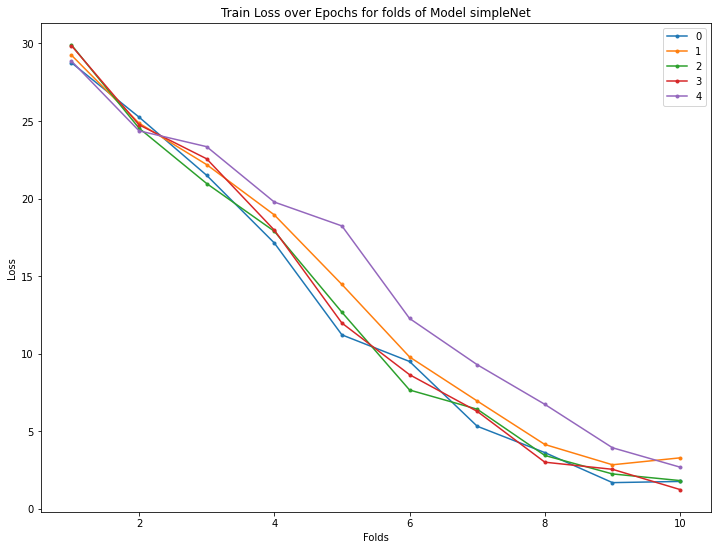

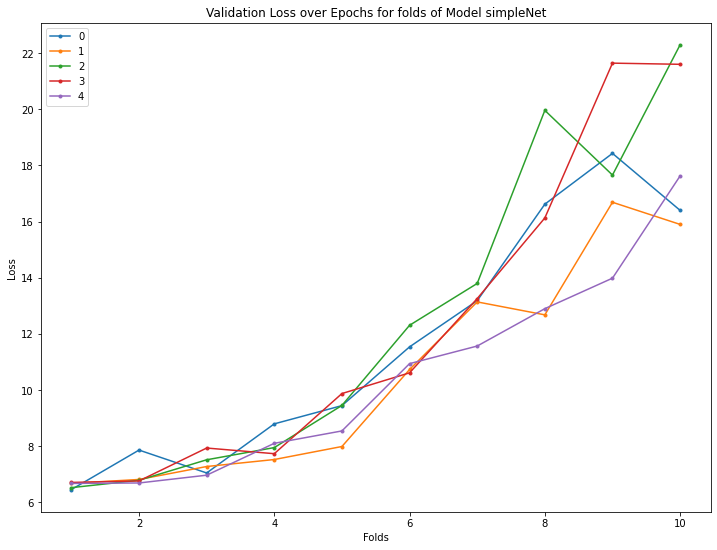

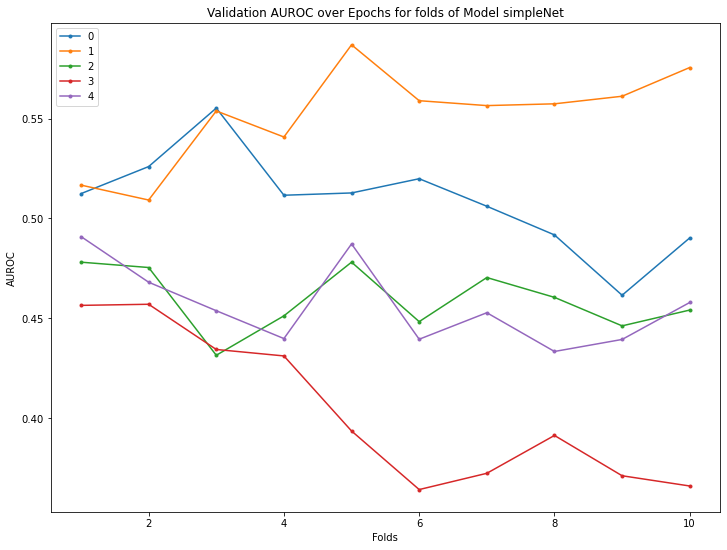

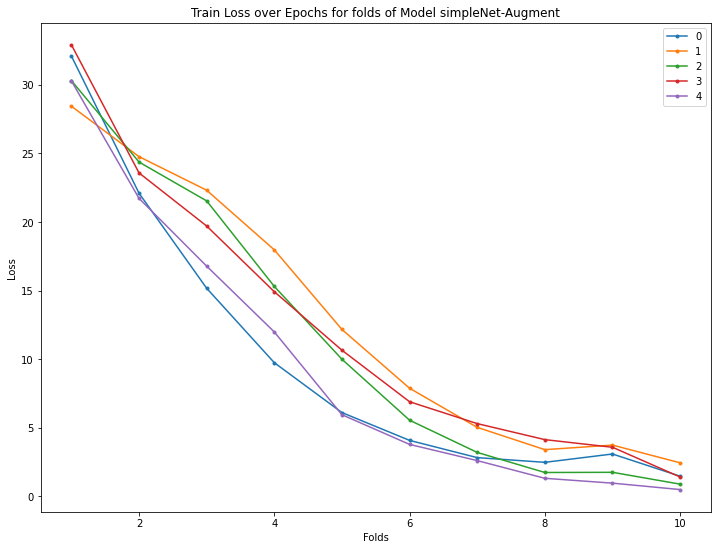

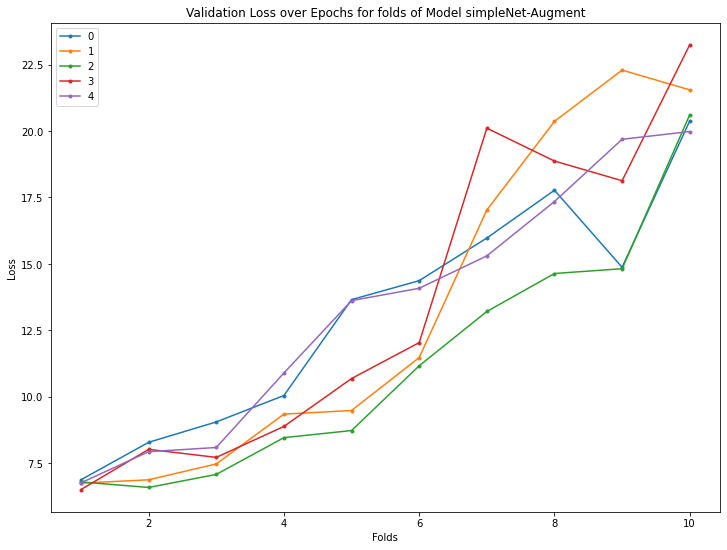

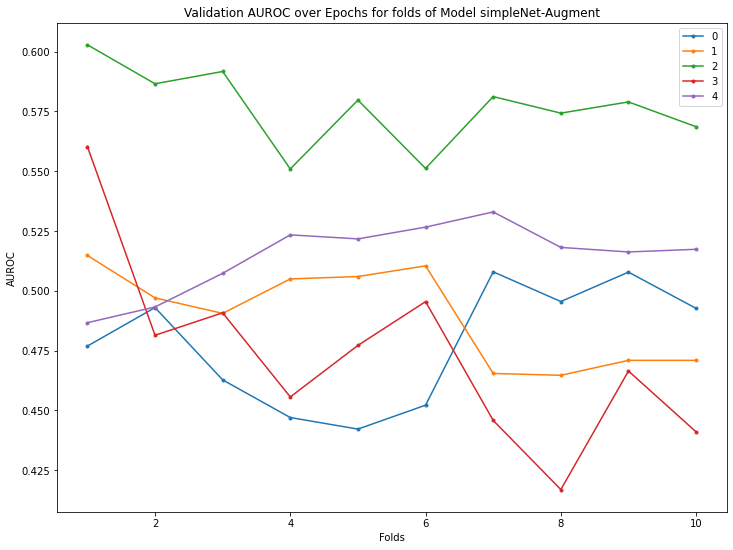

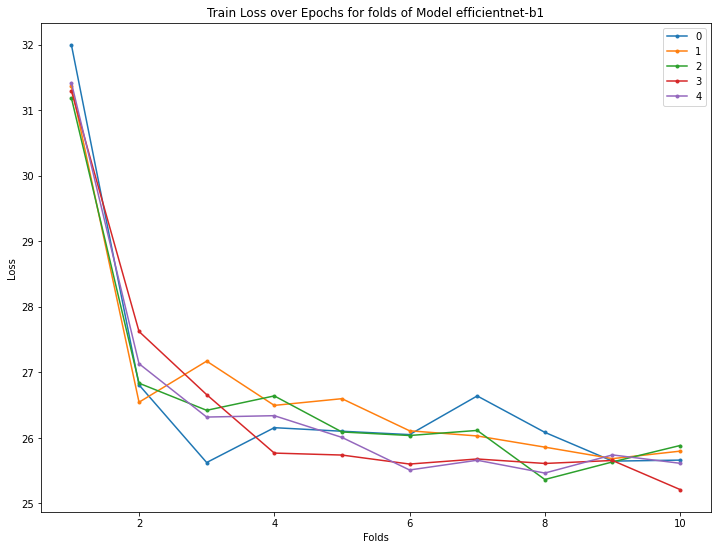

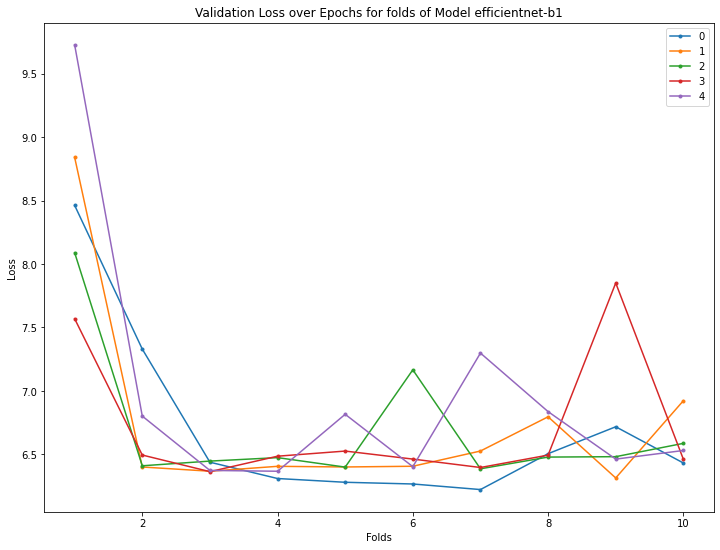

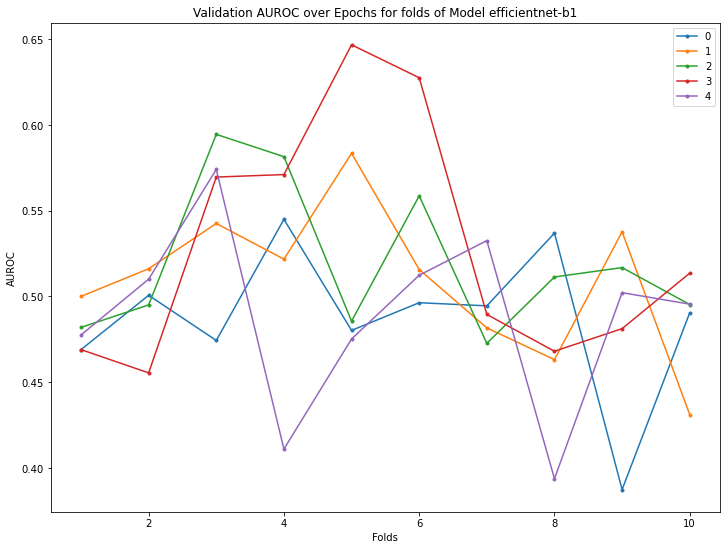

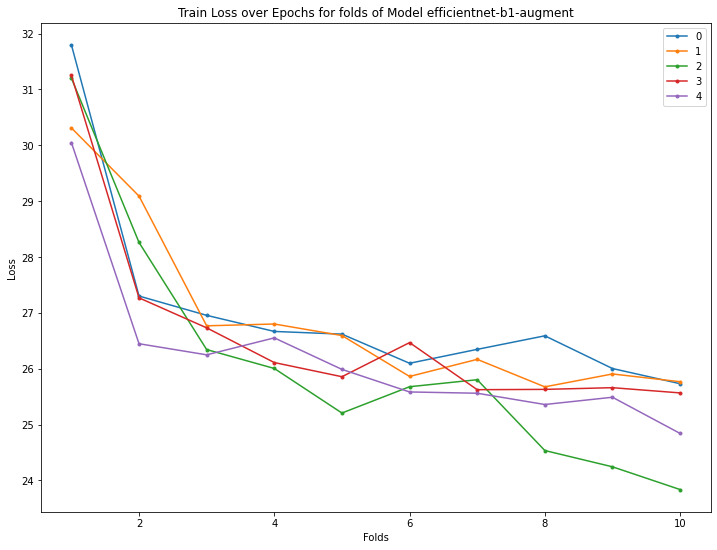

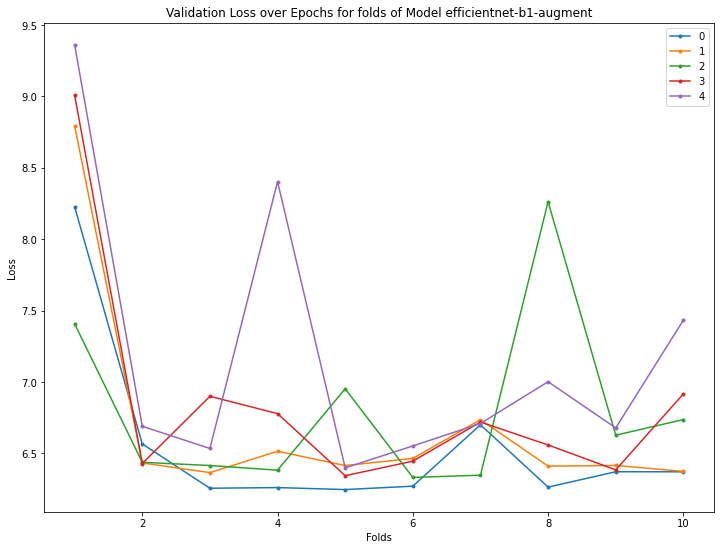

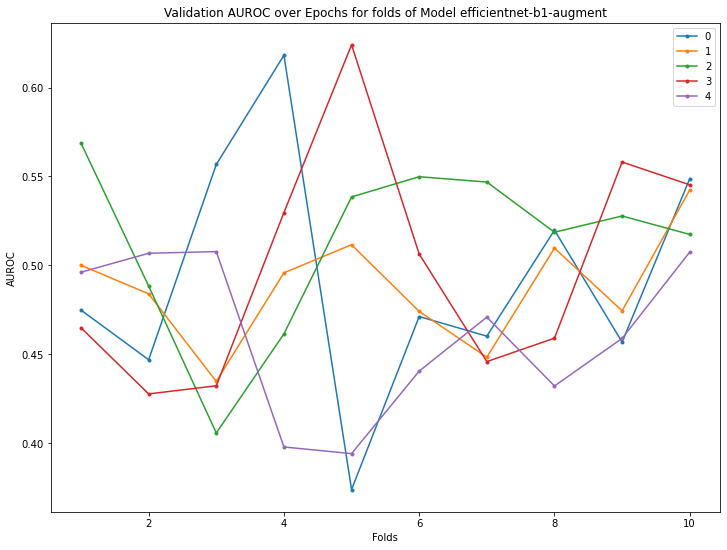

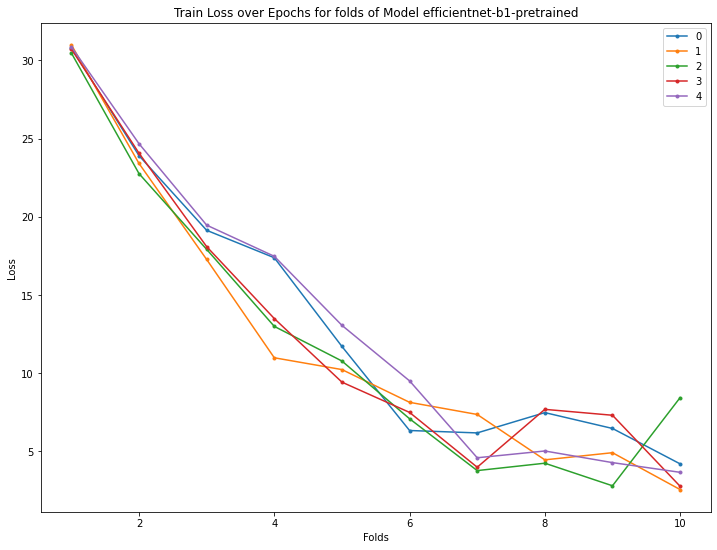

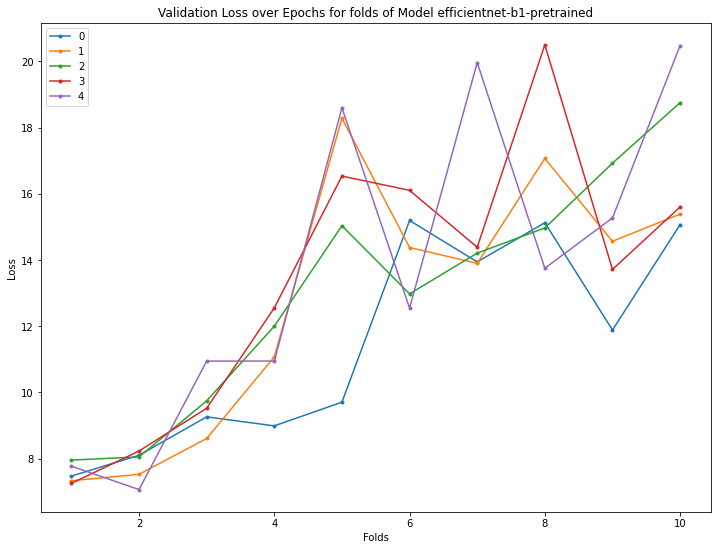

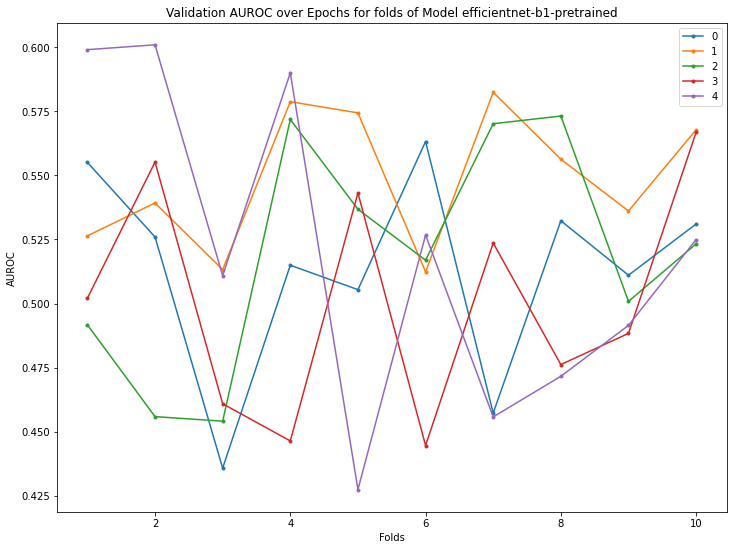

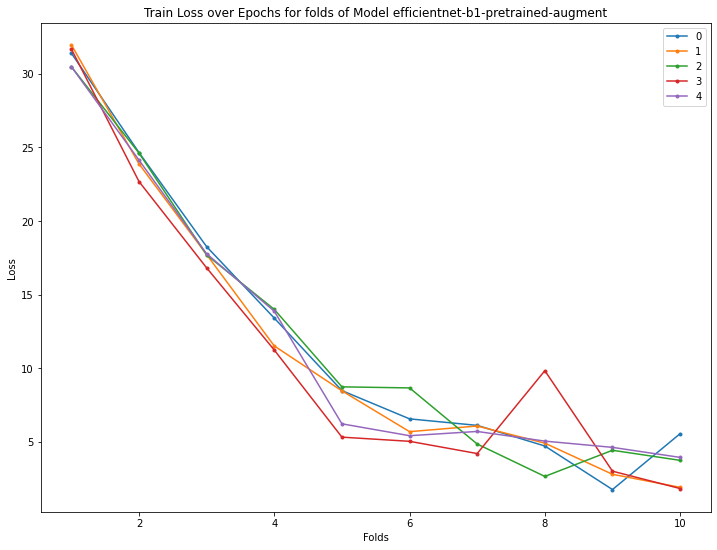

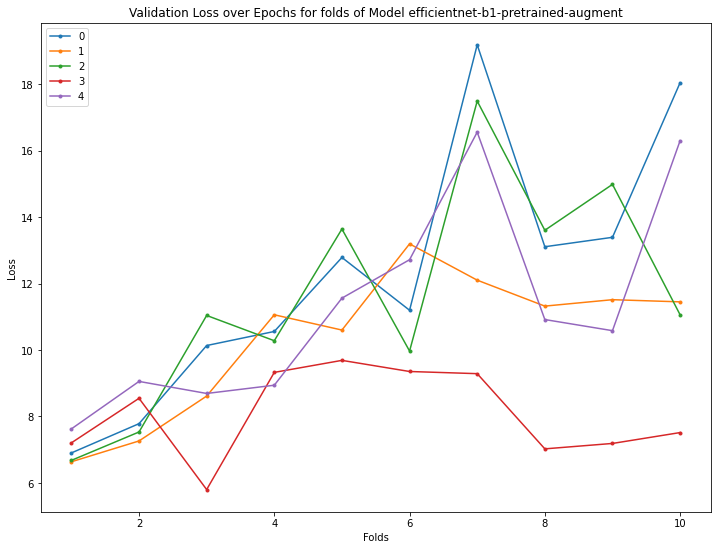

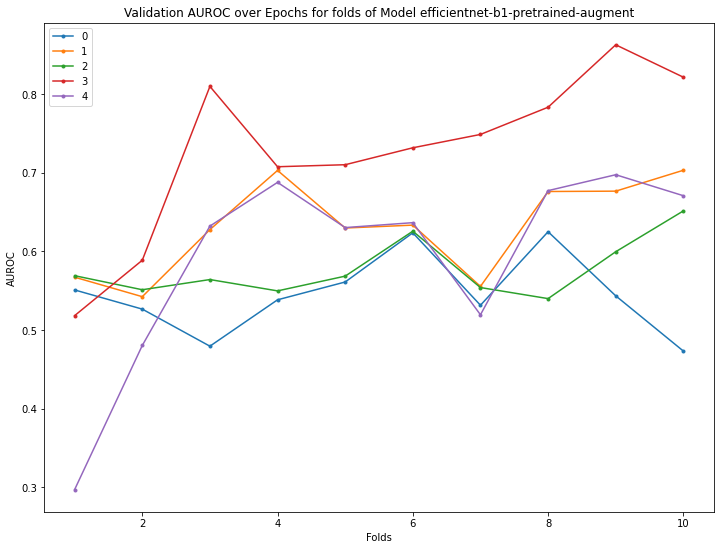

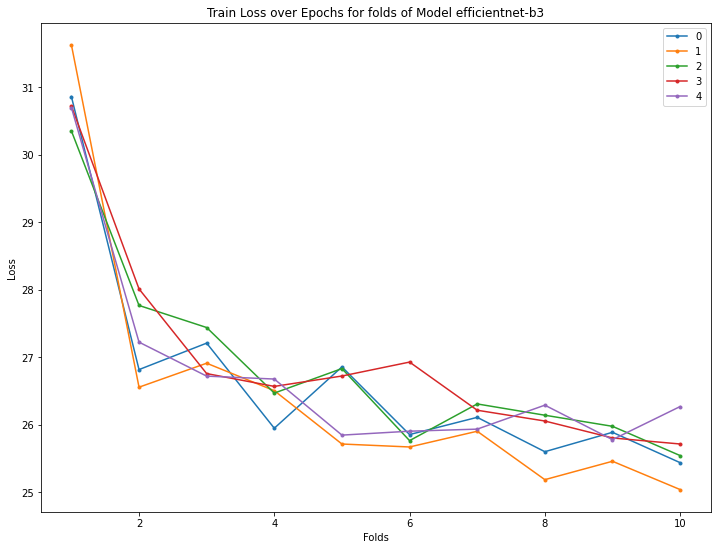

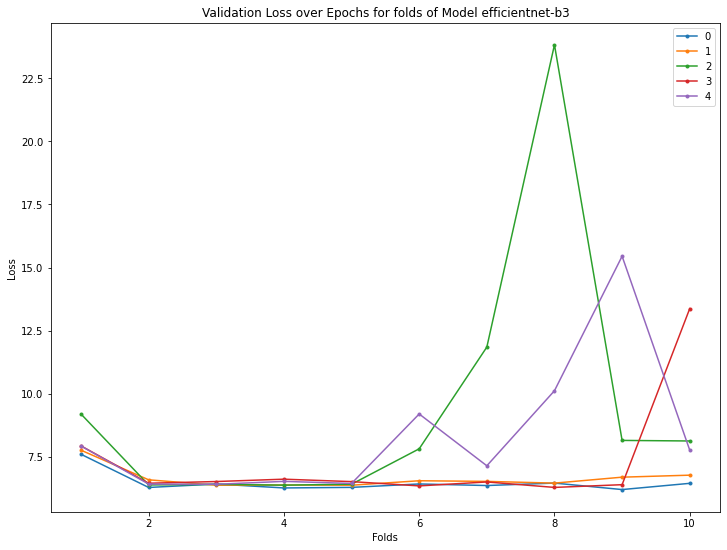

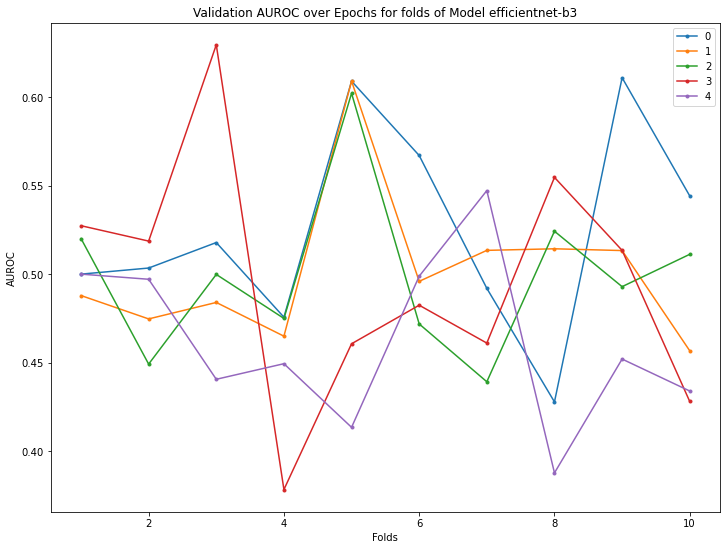

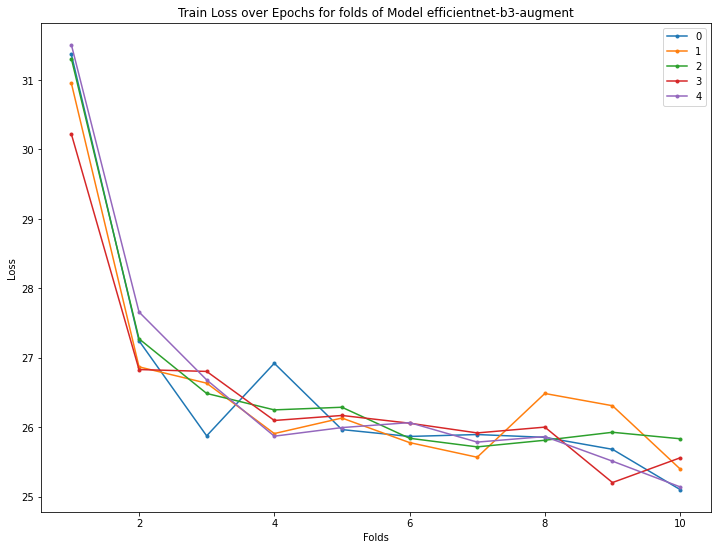

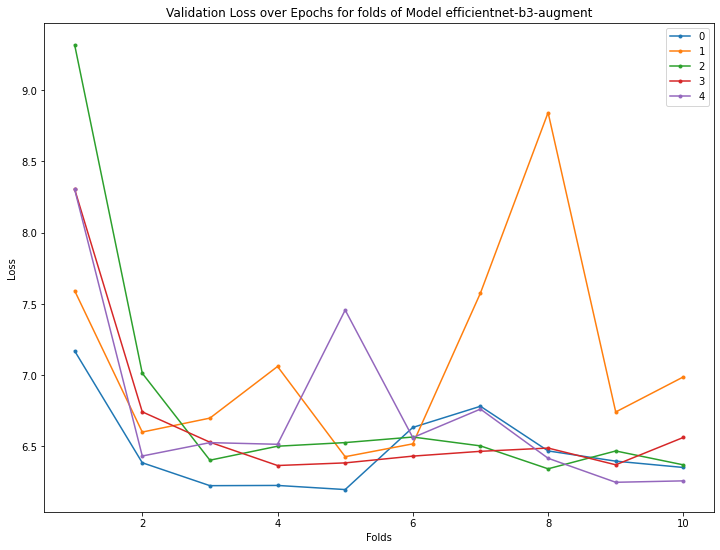

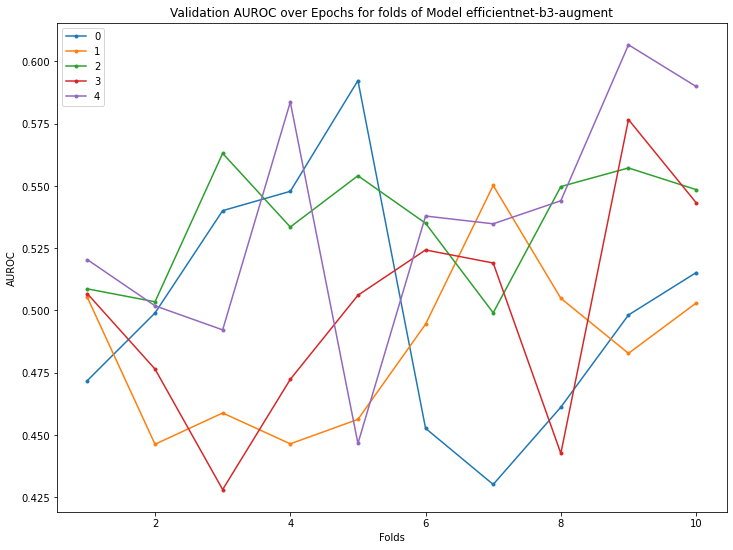

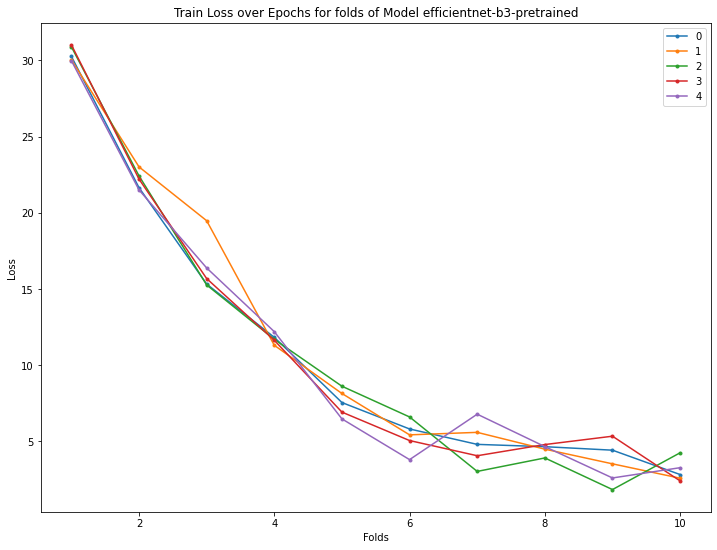

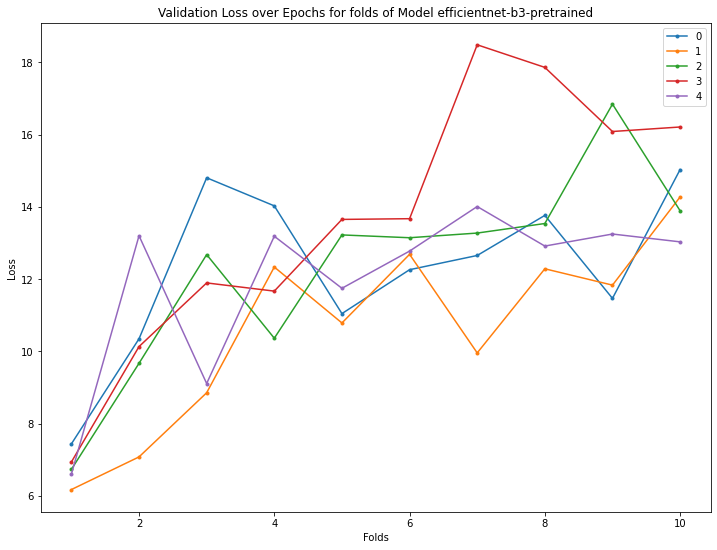

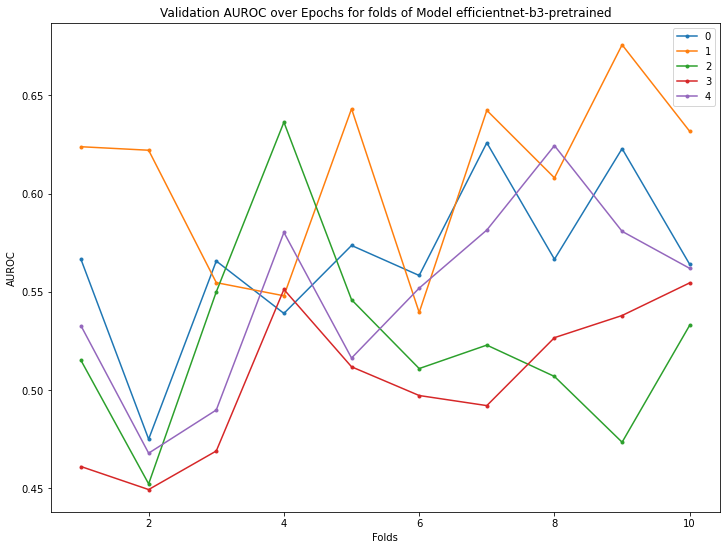

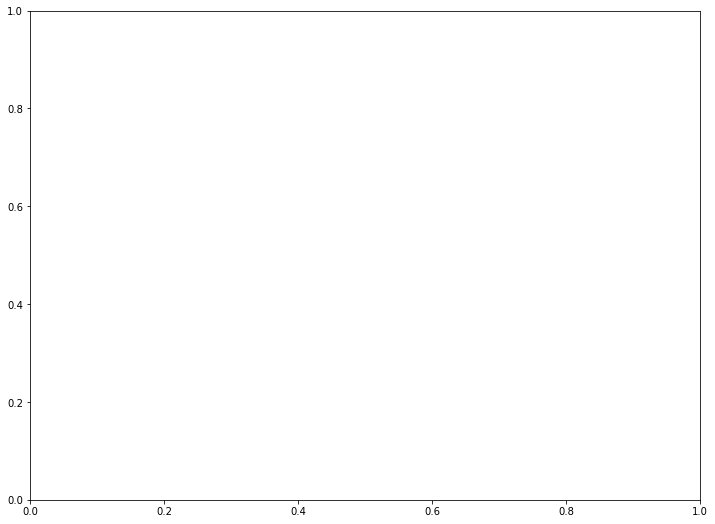

In [15]:
for i in range(len(models)):
    plt.figure(figsize=(12,9))
    for j in range(5):
        plt.plot(range(1, epochs[i][j]+1), train_losses[i][j], label=j, marker=".")
    plt.xlabel("Folds")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Train Loss over Epochs for folds of Model {names[i]}")
    
    plt.figure(figsize=(12,9))
    for j in range(5):
        plt.plot(range(1, epochs[i][j]+1), valid_losses[i][j], label=j, marker=".")
    plt.xlabel("Folds")
    plt.ylabel("Loss")
    plt.legend()
    plt.title(f"Validation Loss over Epochs for folds of Model {names[i]}")
    
    plt.figure(figsize=(12,9))
    for j in range(5):
        plt.plot(range(1, epochs[i][j]+1), aurocs[i][j], label=j, marker=".")
    plt.xlabel("Folds")
    plt.ylabel("AUROC")
    plt.legend()
    plt.title(f"Validation AUROC over Epochs for folds of Model {names[i]}")